In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from pandas.tseries.offsets import DateOffset
import matplotlib.dates as mdates

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
def load_and_prepare_data(file_name):
    df = pd.read_csv(file_name, header=3)  #adjust header=2 for single .csv files, header=3 for compiled files

    color_dict = {'Green': 0, 'Yellow': 1, 'Red': 2, 'Error':3}
    df['alignment_mapped'] = df['Alignment'].map(color_dict)
    df['time_local'] = pd.to_datetime(df['time_local'])

    device_name = df['name'].iloc[0]  # get device name from the 'name' column
    
 # Get the first and last dates in the dataset
    min_date = df['time_local'].min().date()
    max_date = df['time_local'].max().date()

# exclude data points from the first and last days
    df = df[(df['time_local'].dt.date != min_date) & (df['time_local'].dt.date != max_date)]

    return df, device_name

In [3]:
def plot_displacement(df, device_name):
    min_date = df['time_local'].min().strftime('%Y-%m-%d')
    max_date = df['time_local'].max().strftime('%Y-%m-%d')
    instance_name = df['instance'].iloc[0]

    fig, ax = plt.subplots(figsize=(12, 10))# plot displacement
    ax.plot(df['time_local'], df['um'], label='Displacement')
    
#     plot alignment
    ax.fill_between(df['time_local'], df['um'].max(), df['um'].min(), where=(df['alignment_mapped'] == 0),
                    color='green', alpha=0.5, label='Green Alignment')
    ax.fill_between(df['time_local'], df['um'].max(), df['um'].min(), where=(df['alignment_mapped'] == 1),
                    color='yellow', alpha=1, label='Yellow Alignment')
    ax.fill_between(df['time_local'], df['um'].max(), df['um'].min(), where=(df['alignment_mapped'] == 2),
                    color='red', alpha=1, label='Red Alignment')
    ax.fill_between(df['time_local'], df['um'].max(), df['um'].min(), where=(df['alignment_mapped'] == 3),
                    color='purple', alpha=1, label='Error Alignment')
        
    ax.set_title(f'{device_name}: {instance_name} from {min_date} to {max_date}')
    ax.legend()
    plt.tight_layout()
    plt.show()

In [4]:
def identify_and_adjust_outliers(df):
    # Calculate the differences and identify the outliers
    df['Difference'] = df['um'].diff()
    Q1 = df['Difference'].quantile(0.25)
    Q3 = df['Difference'].quantile(0.75)
    IQR = Q3 - Q1
    outlier_indices = df[(df['Difference'] < Q1 - 15.0 * IQR) | (df['Difference'] > Q3 + 15.0 * IQR)].index

    # new column for the adjustment values
    df['Adjustment'] = 0.0

    # Iterate over the outlier indices
    for idx in outlier_indices:
        if idx != 0:  # we can't do this for the first index
            # The adjustment is the difference at the current index
            adjustment = df.loc[idx, 'Difference']

            # Subtract the adjustment from the current and all following displacement values
            df.loc[idx:, 'Adjustment'] += adjustment

    # The cleaned displacement values are the original displacement minus the adjustment
    df['Cleaned Displacement'] = df['um'] - df['Adjustment']

    return df
#print(df)

In [5]:
def plot_cleaned_displacement(df, device_name):
    
    instance_name = df['instance'].iloc[0]
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].plot(df['time_local'], df['um'])
    ax[0].set_title(f'{device_name}: {instance_name}.Original Displacement')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Displacement')

    ax[1].plot(df['time_local'], df['Cleaned Displacement'])
    ax[1].set_title(f'{device_name}: {instance_name}. Cleaned Displacement')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Displacement')
    
    for axis in ax:
        labels = axis.get_xticklabels()
        plt.setp(labels, rotation=45, ha='right')  # Rotate labels by 45 degrees

    plt.tight_layout()
    plt.show()

In [6]:
df, device_name = load_and_prepare_data('H6_complete.csv')  # also get device_name

In [7]:
# # #plot cleaned data
# identify_and_adjust_outliers(df)
# plot_cleaned_displacement(df, device_name)

In [8]:
cleaned_df = identify_and_adjust_outliers(df)

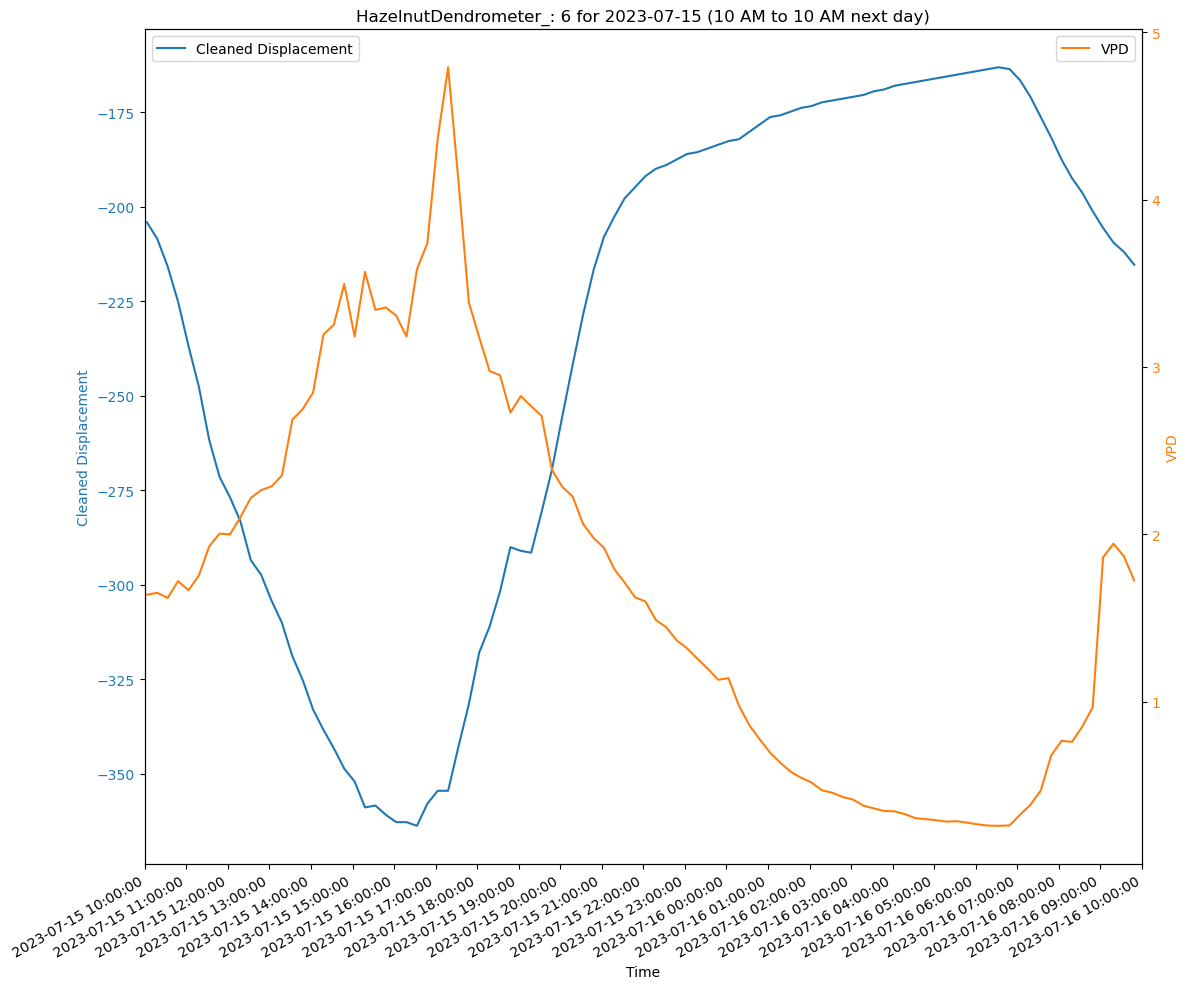

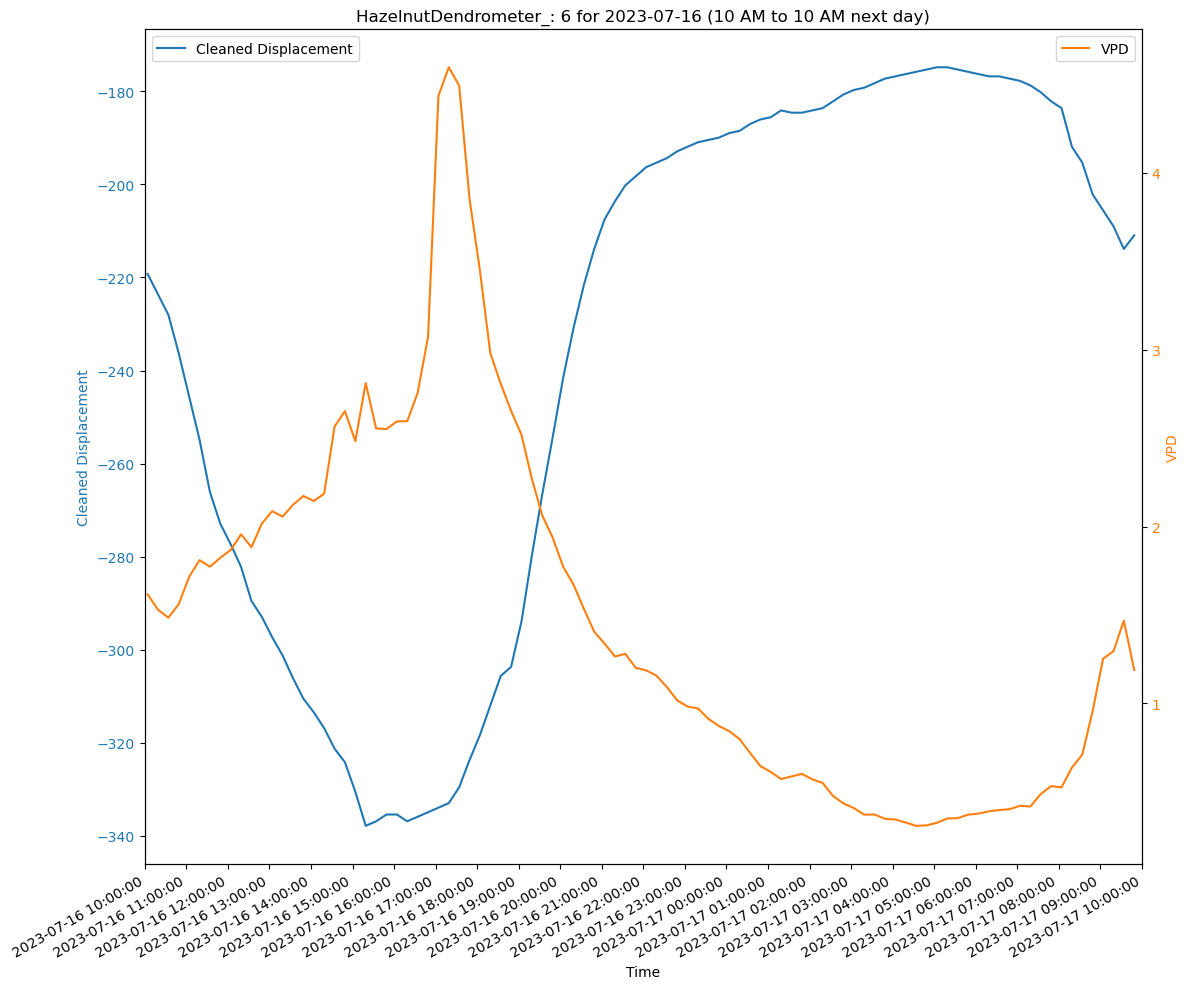

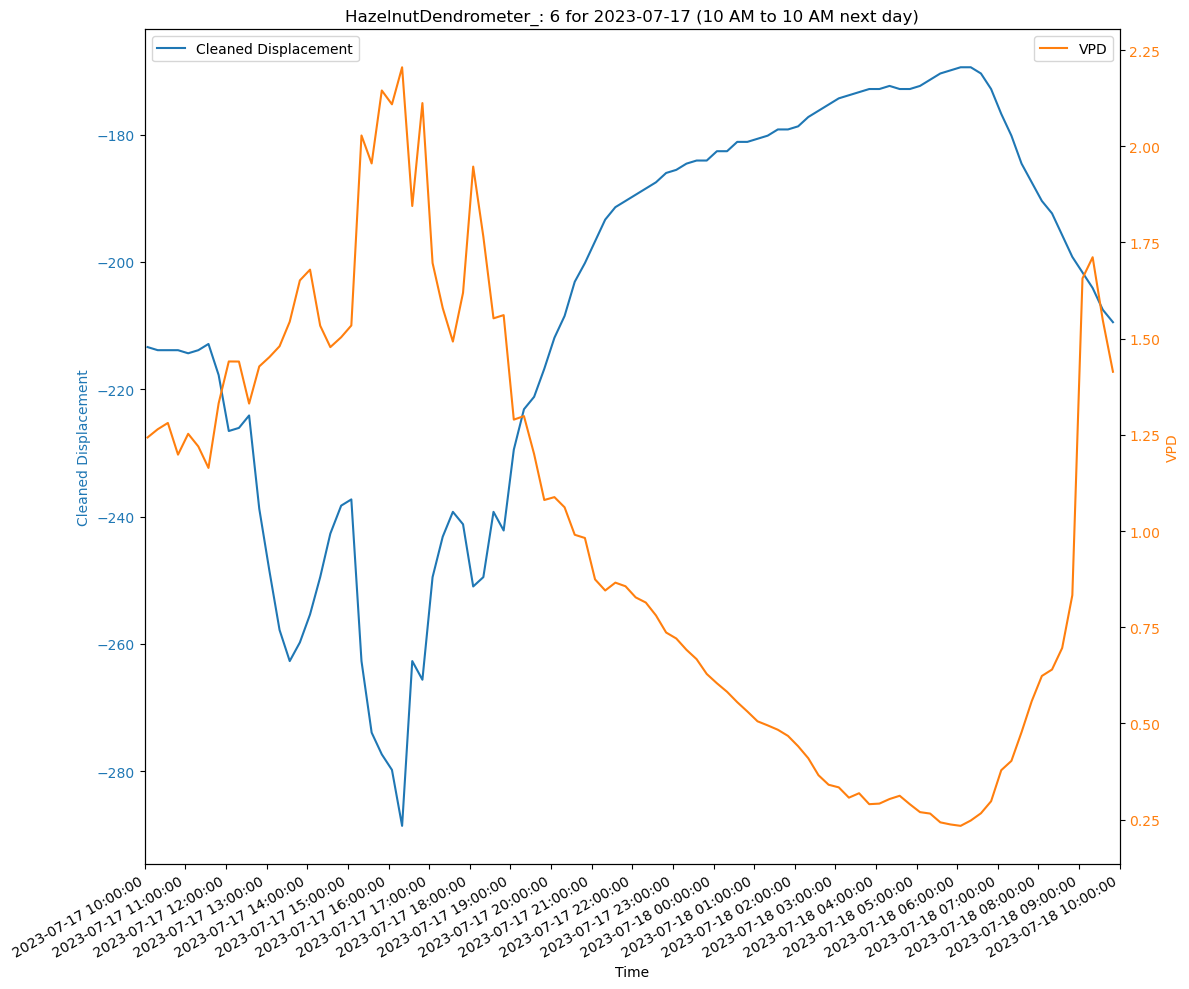

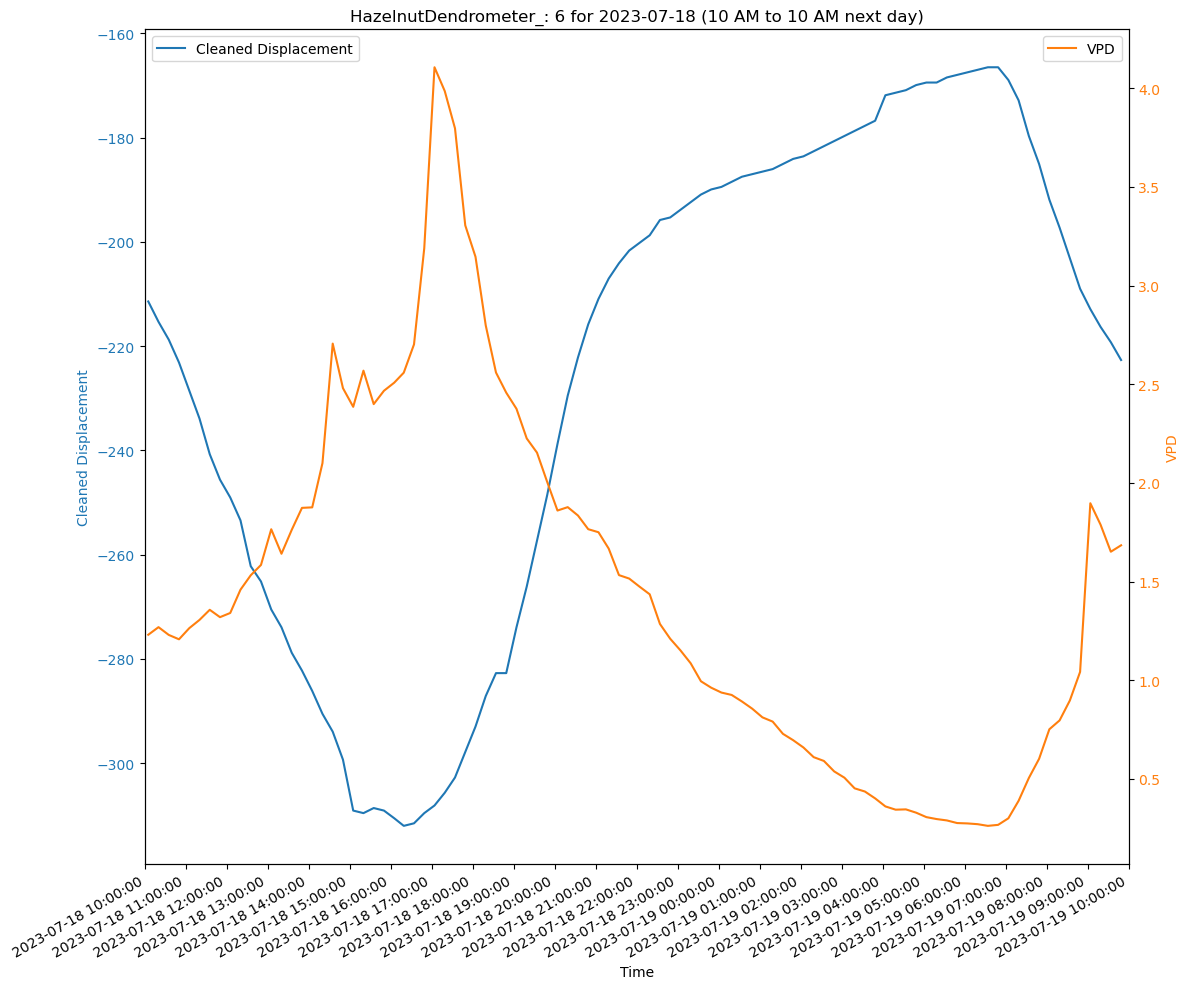

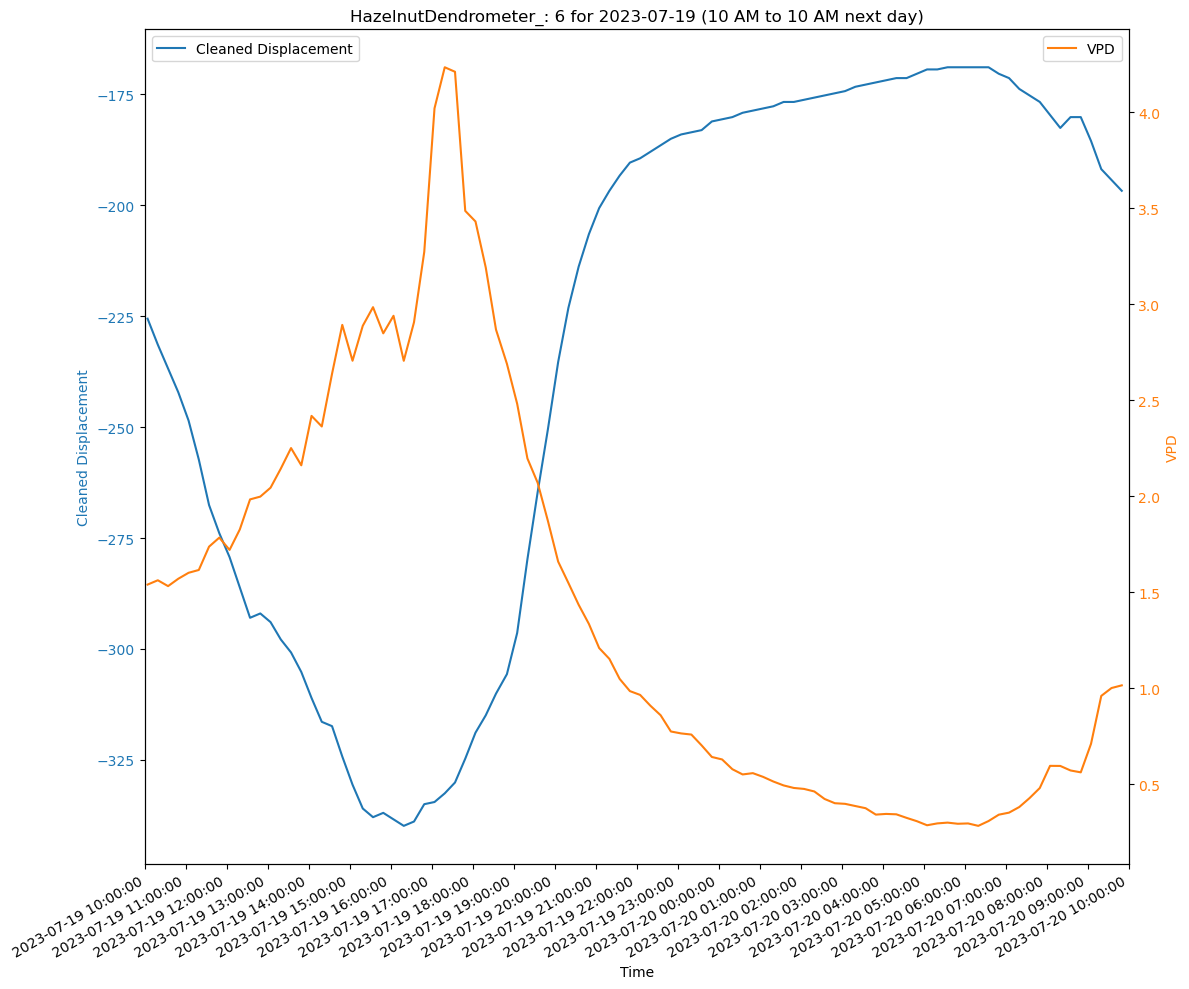

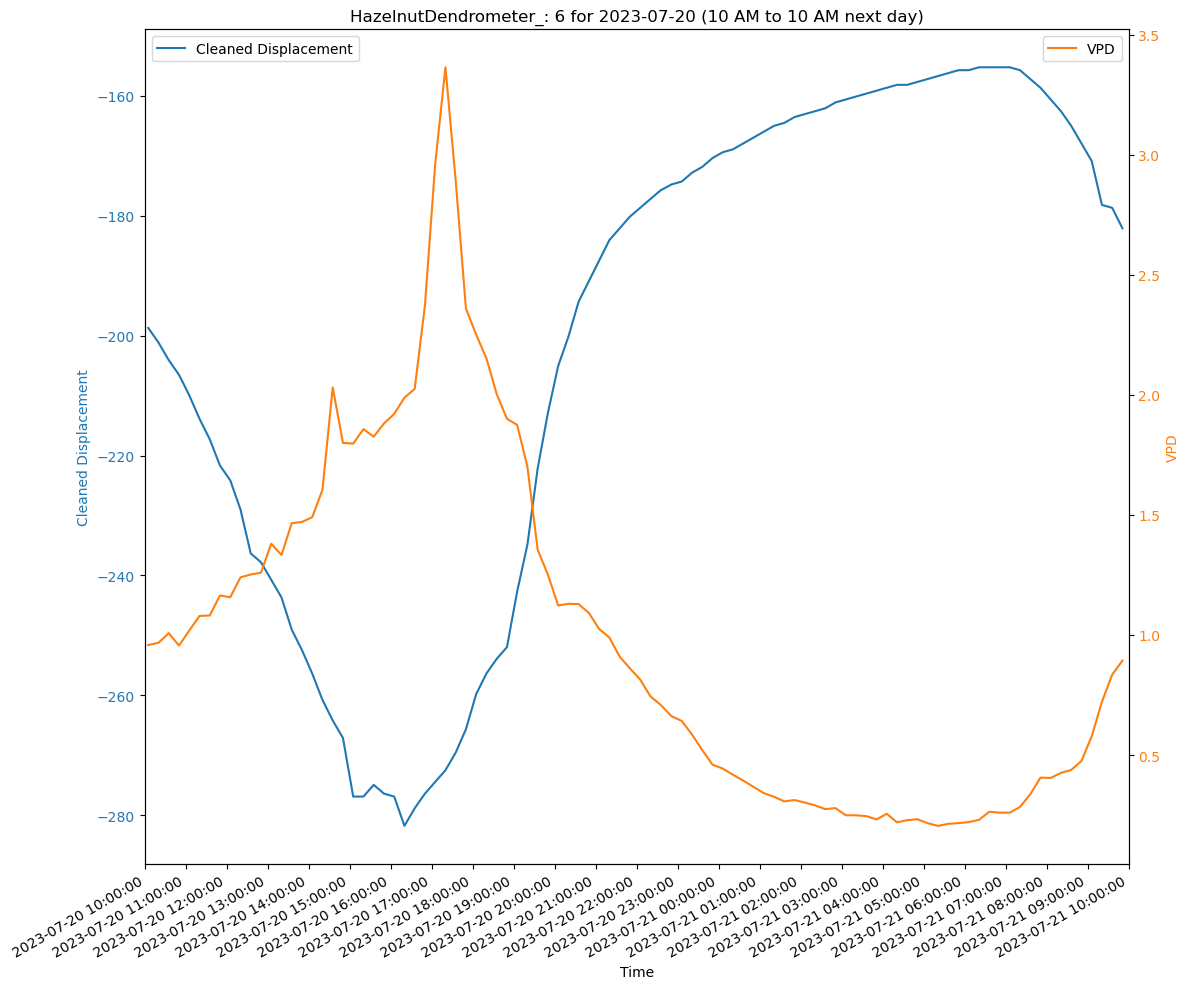

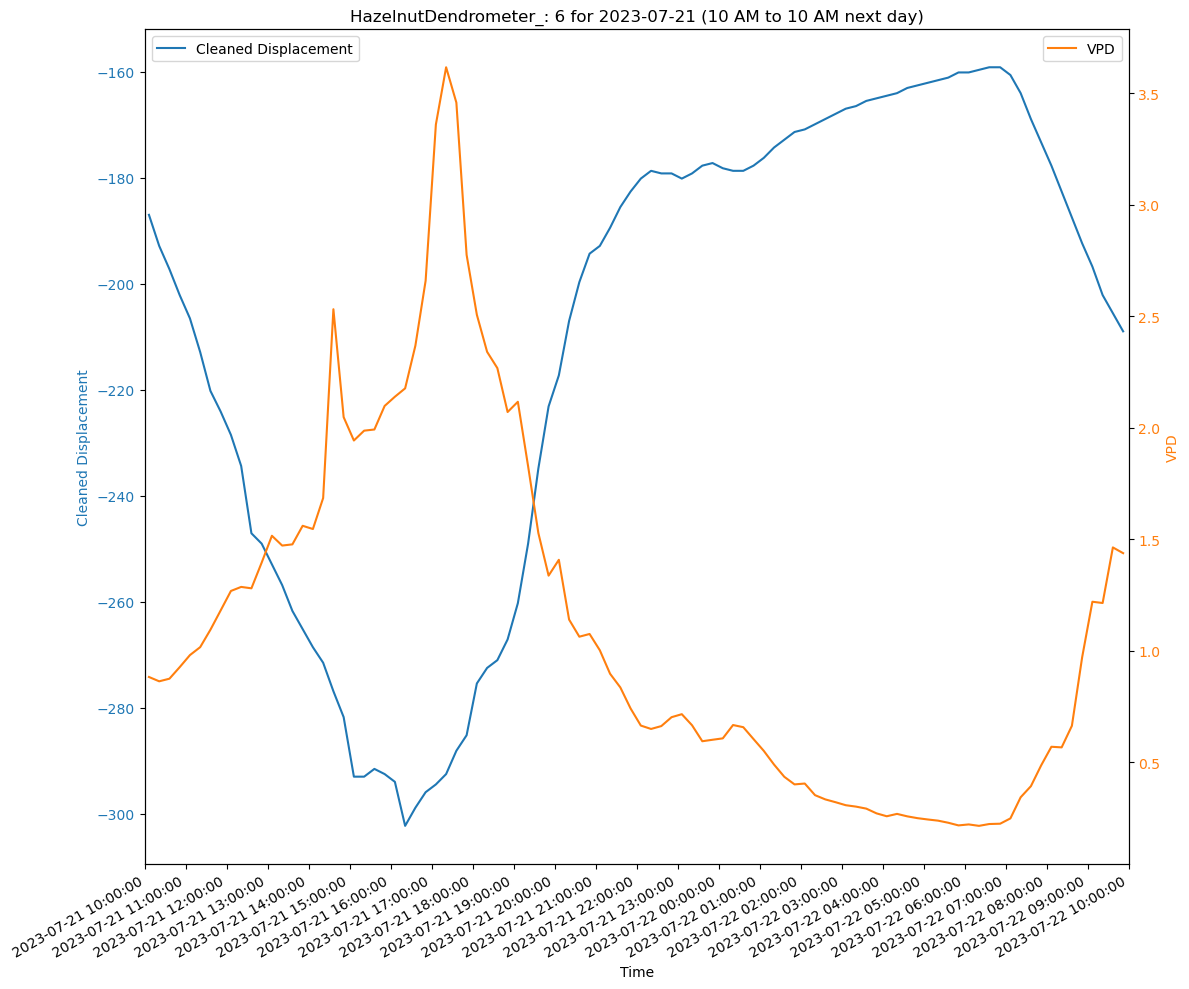

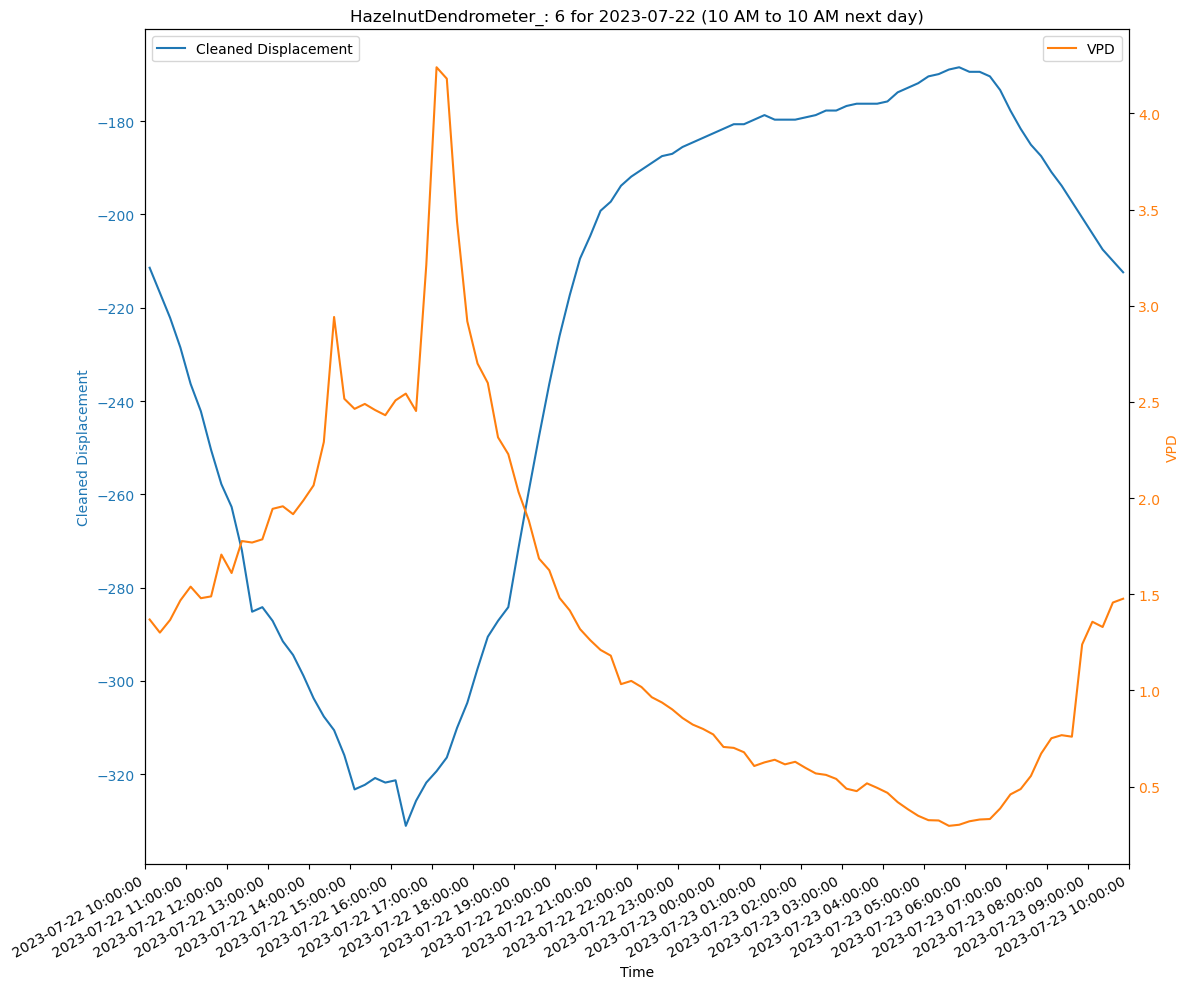

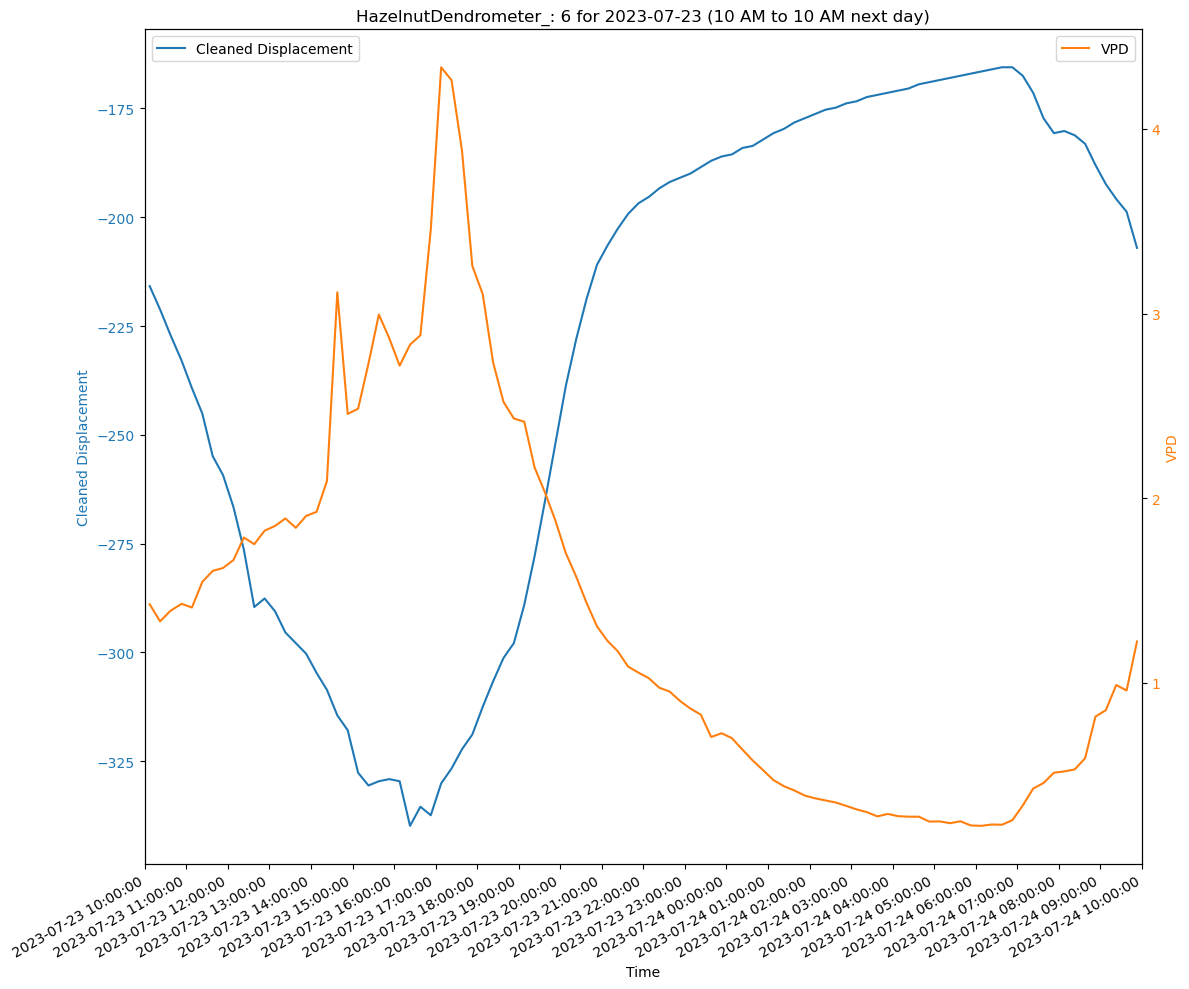

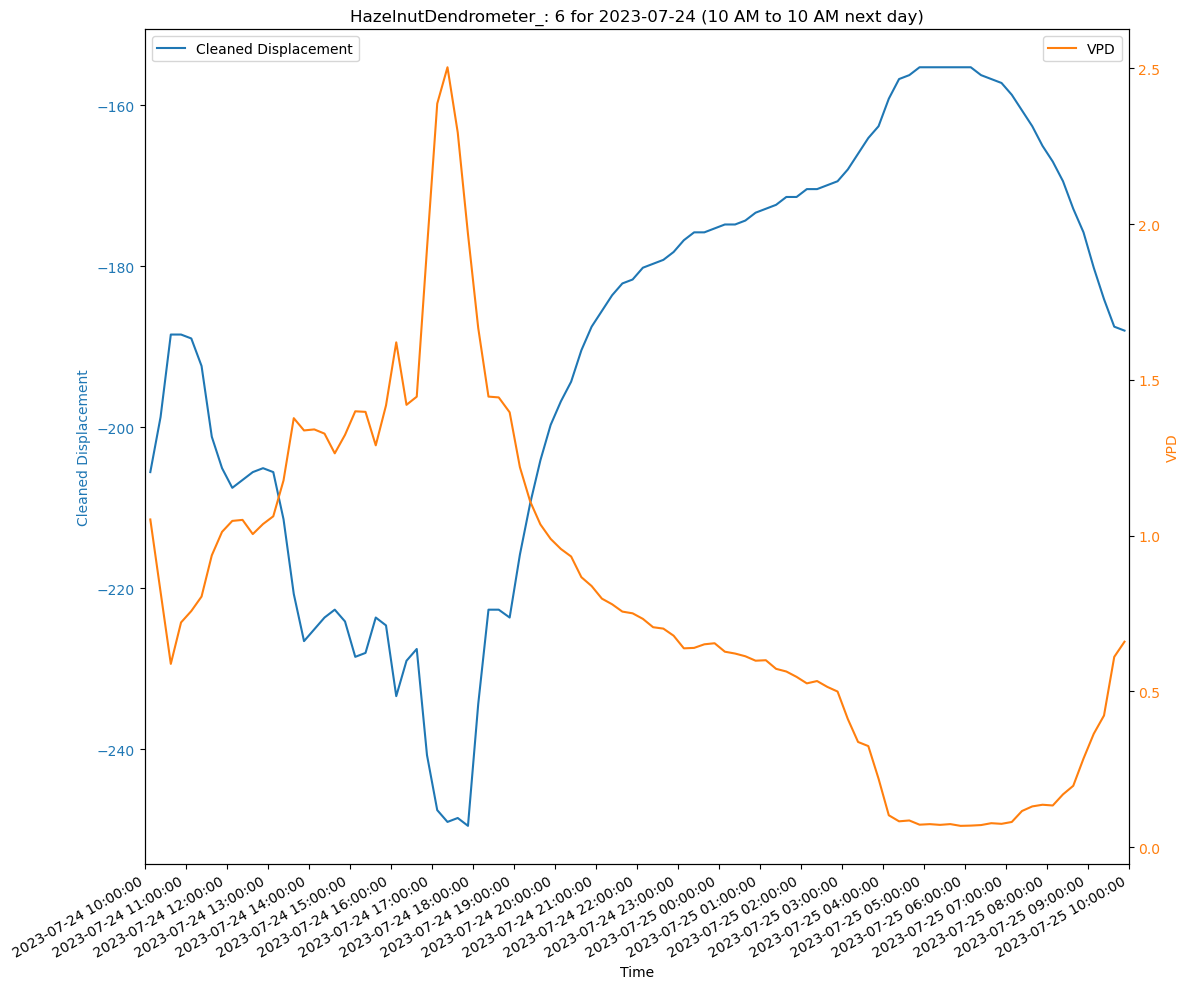

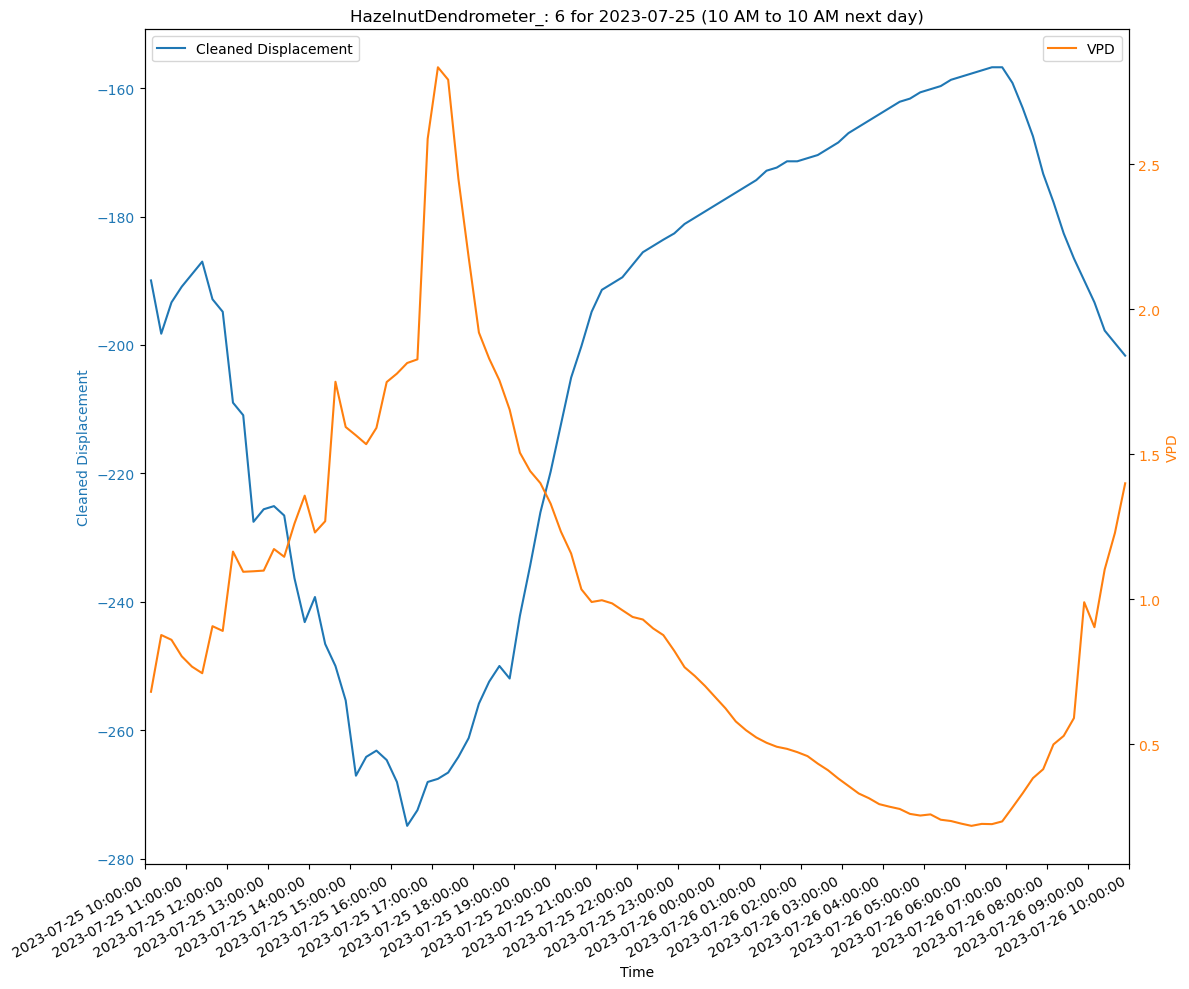

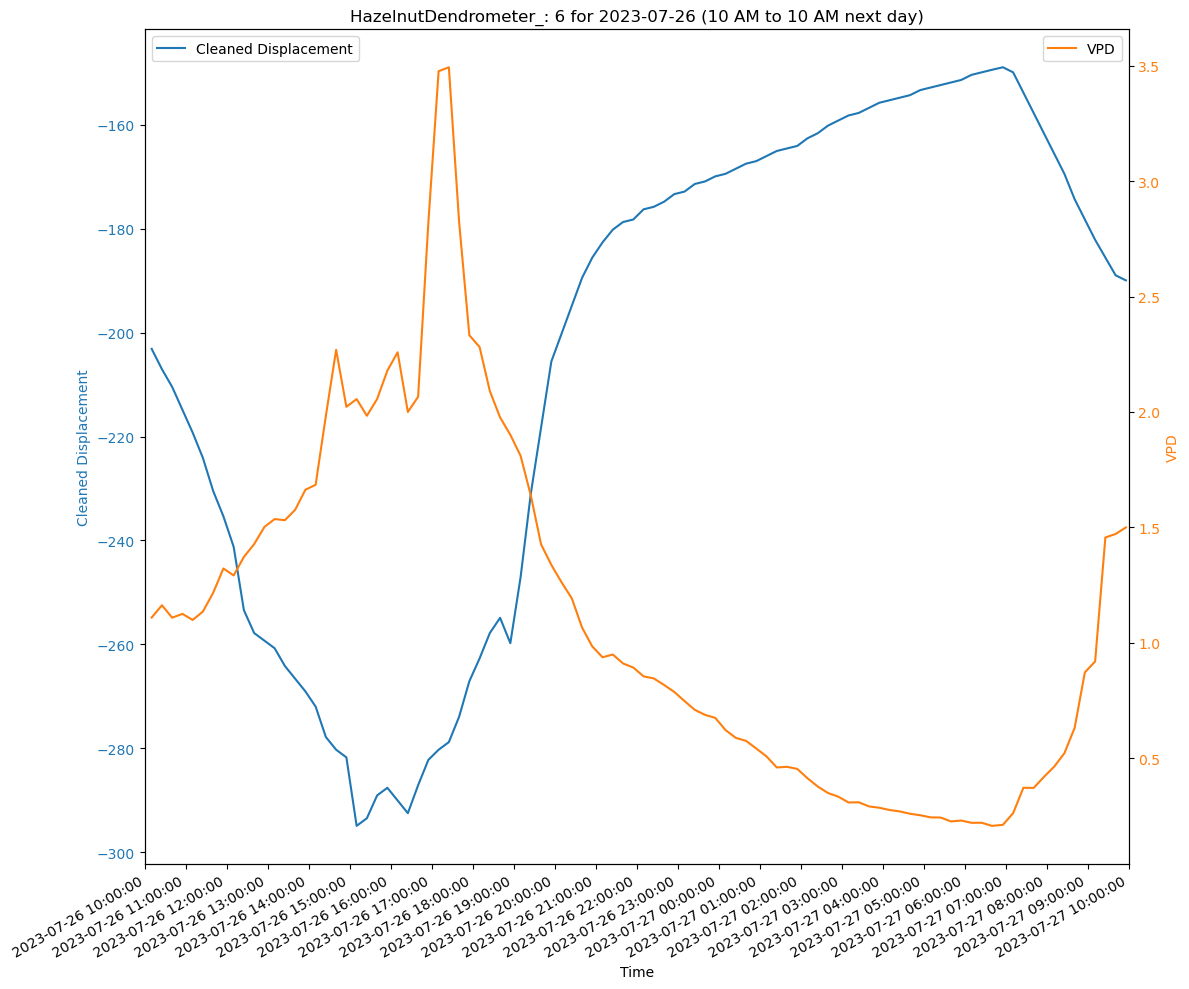

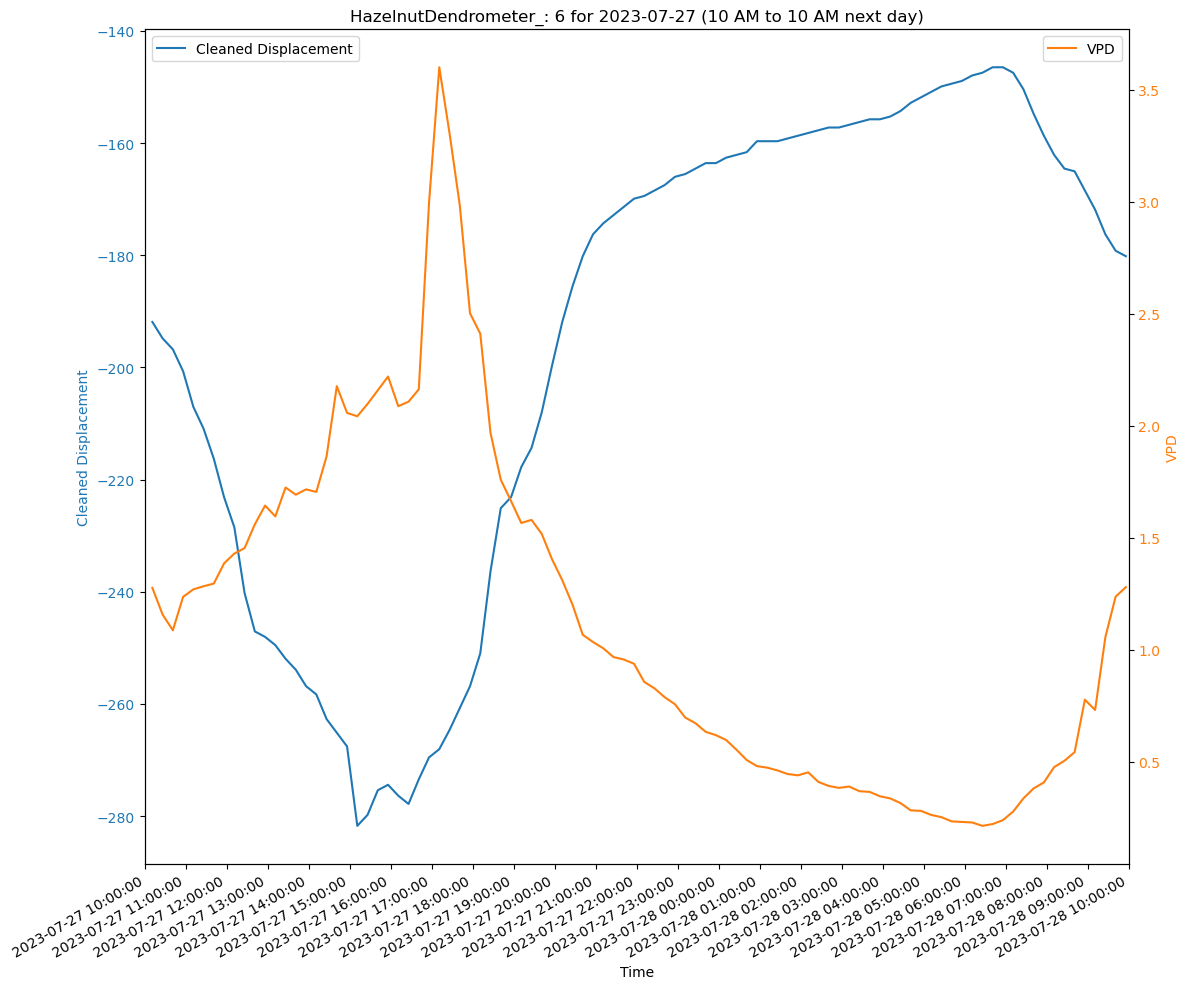

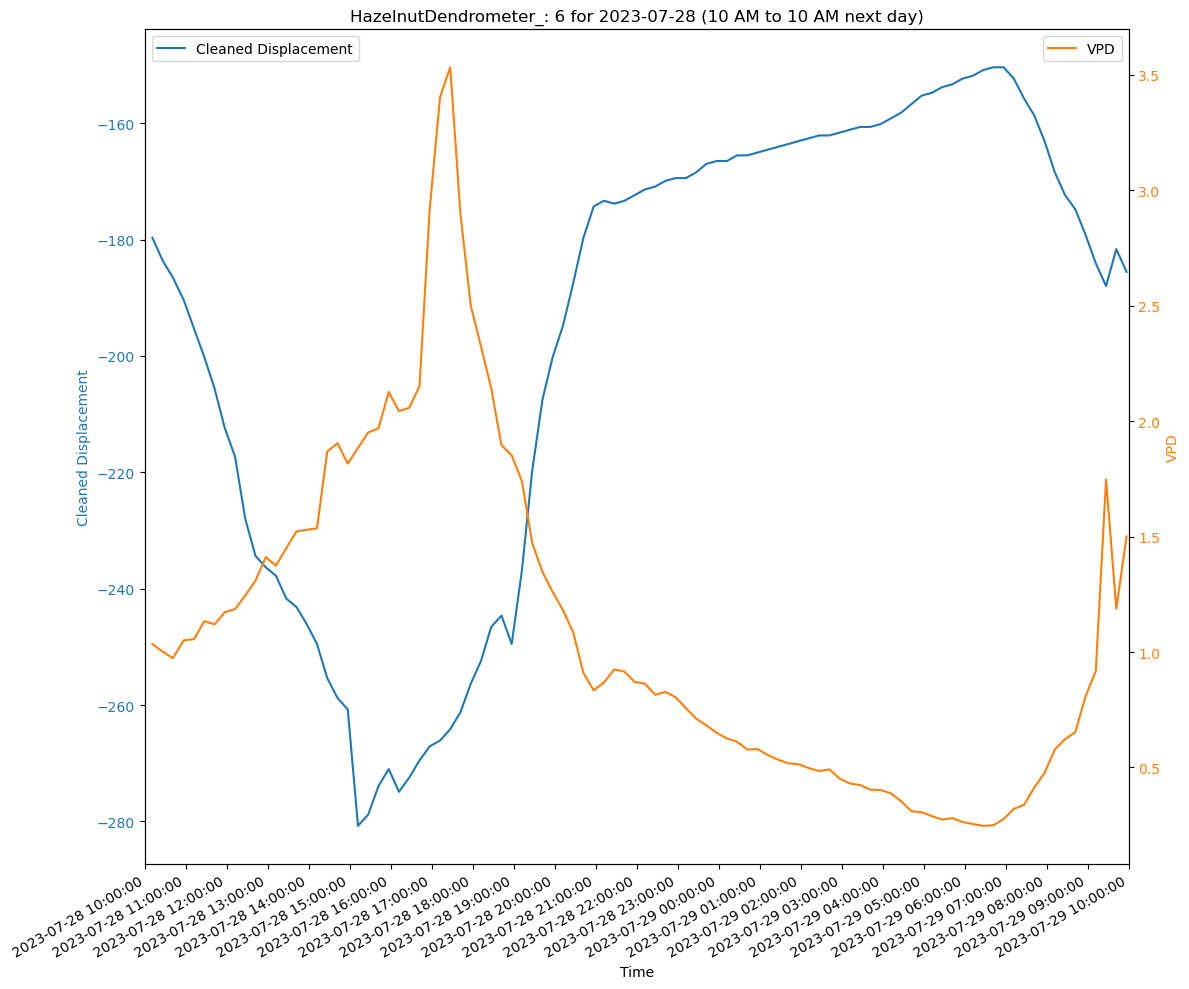

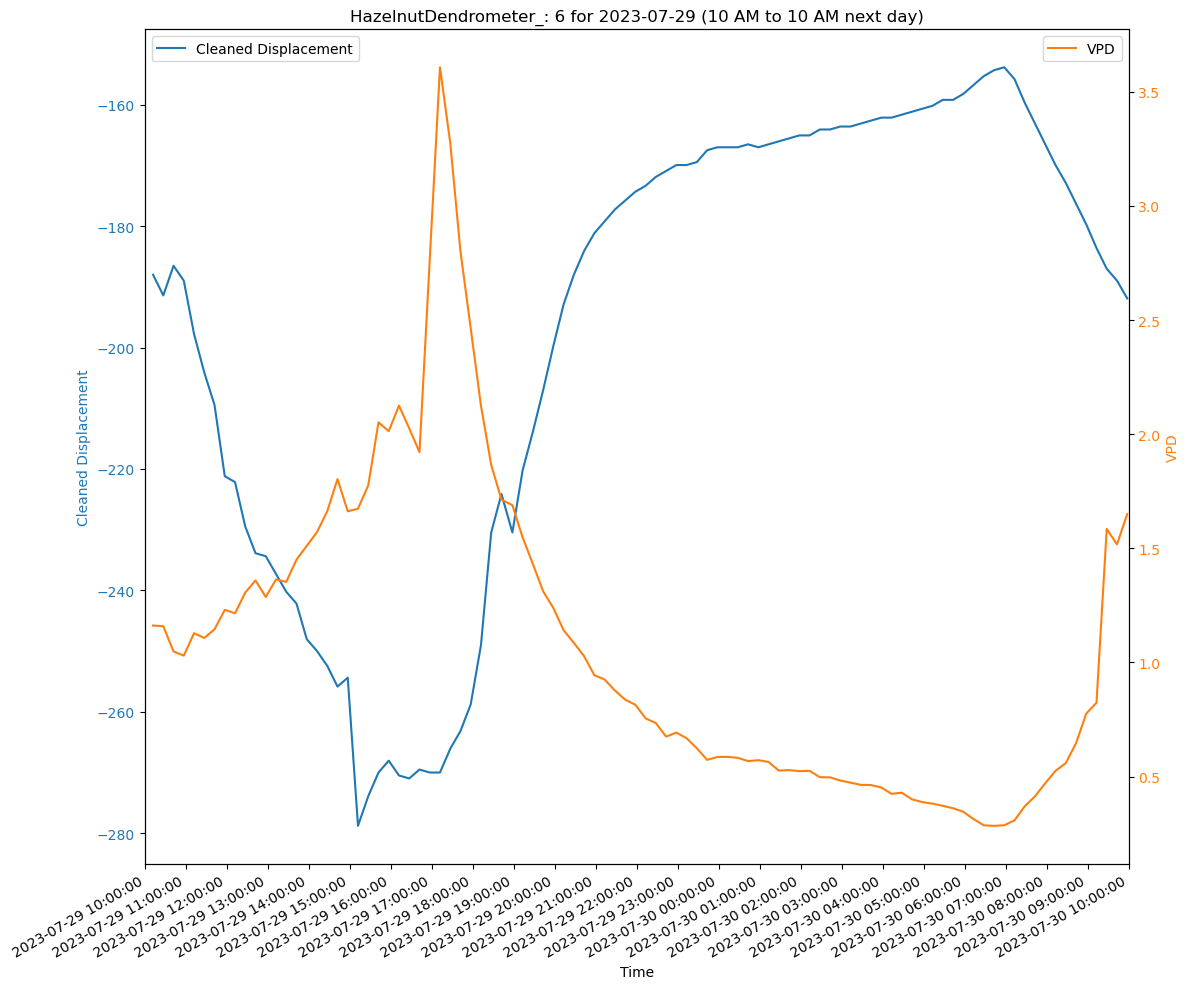

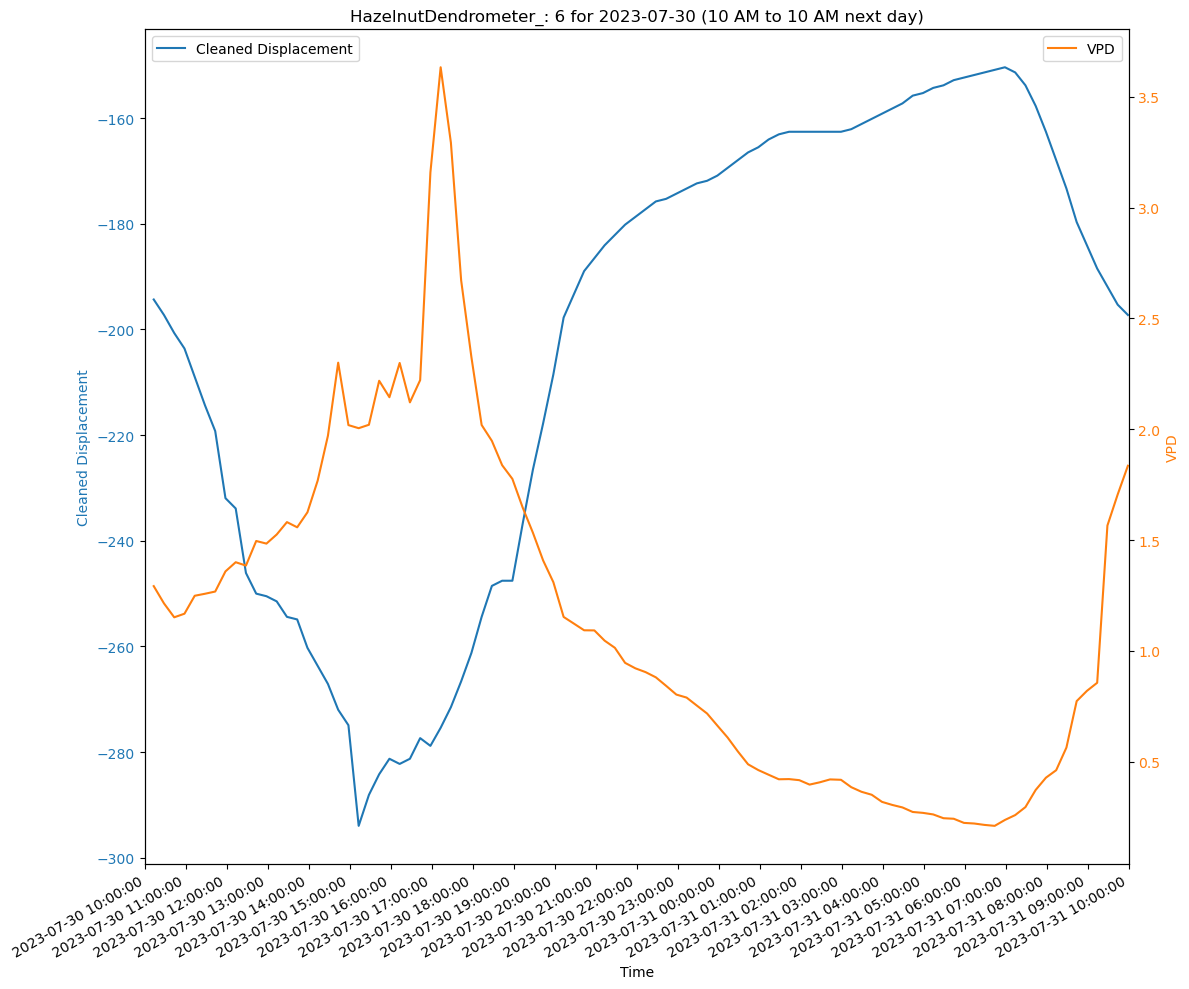

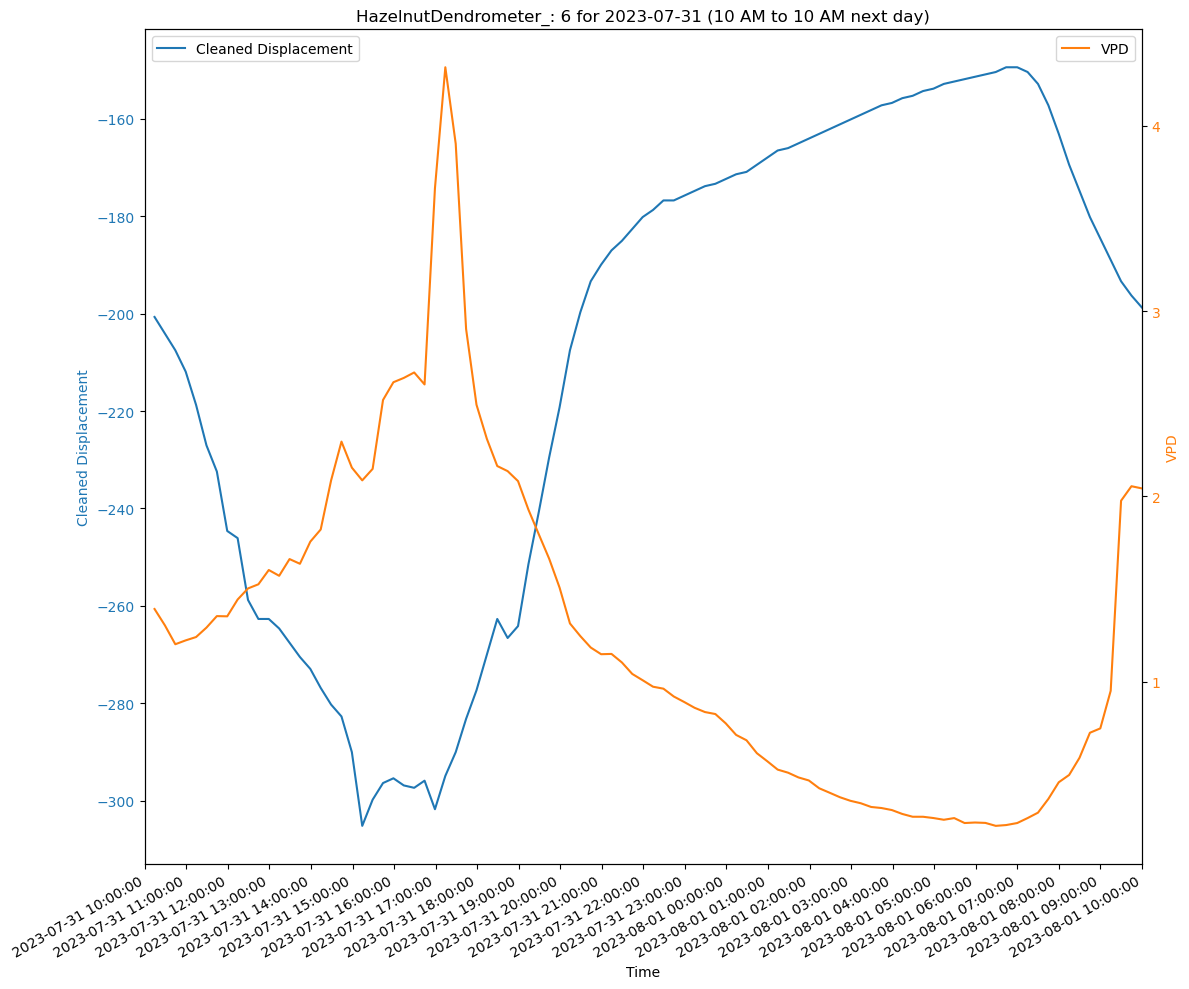

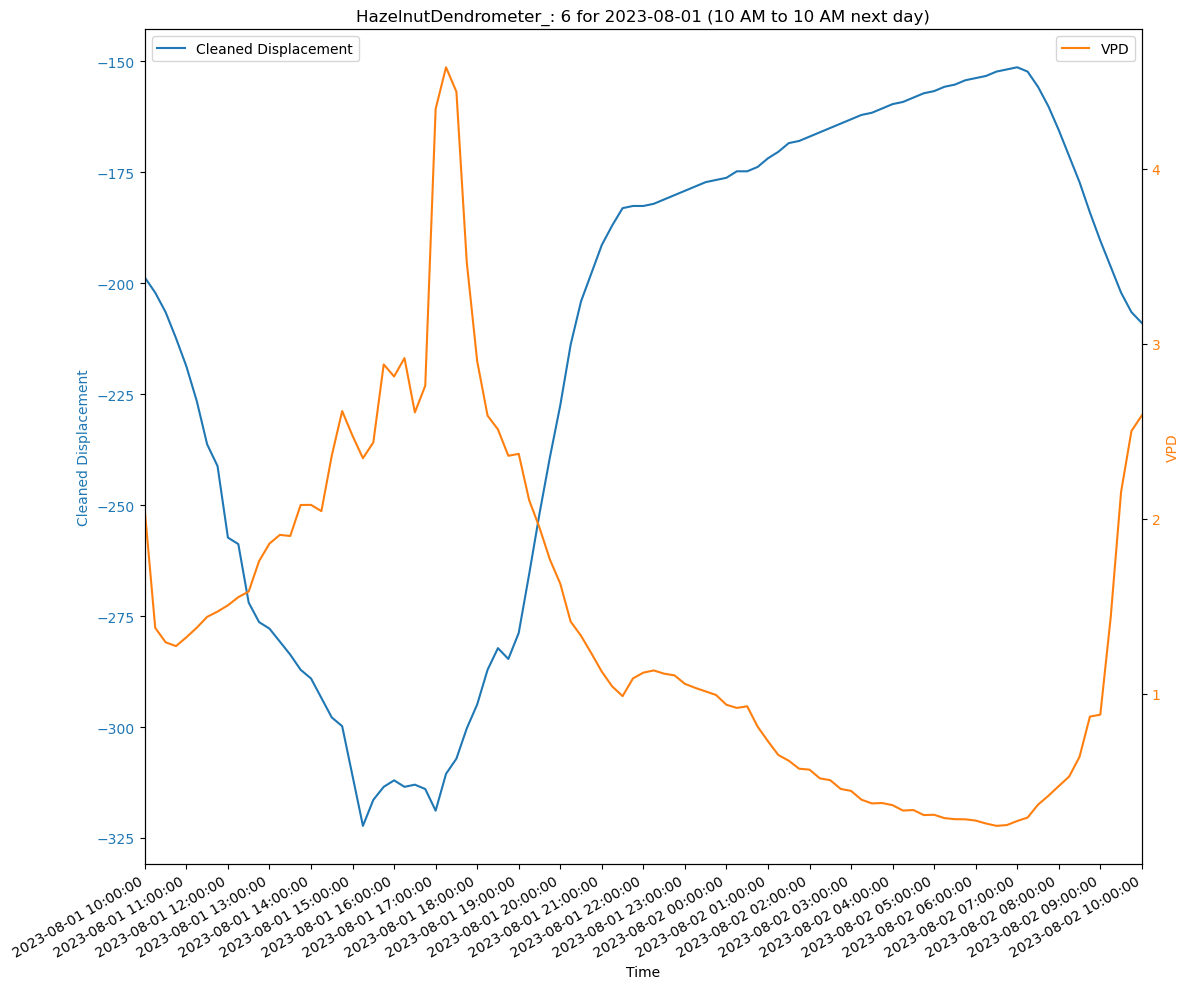

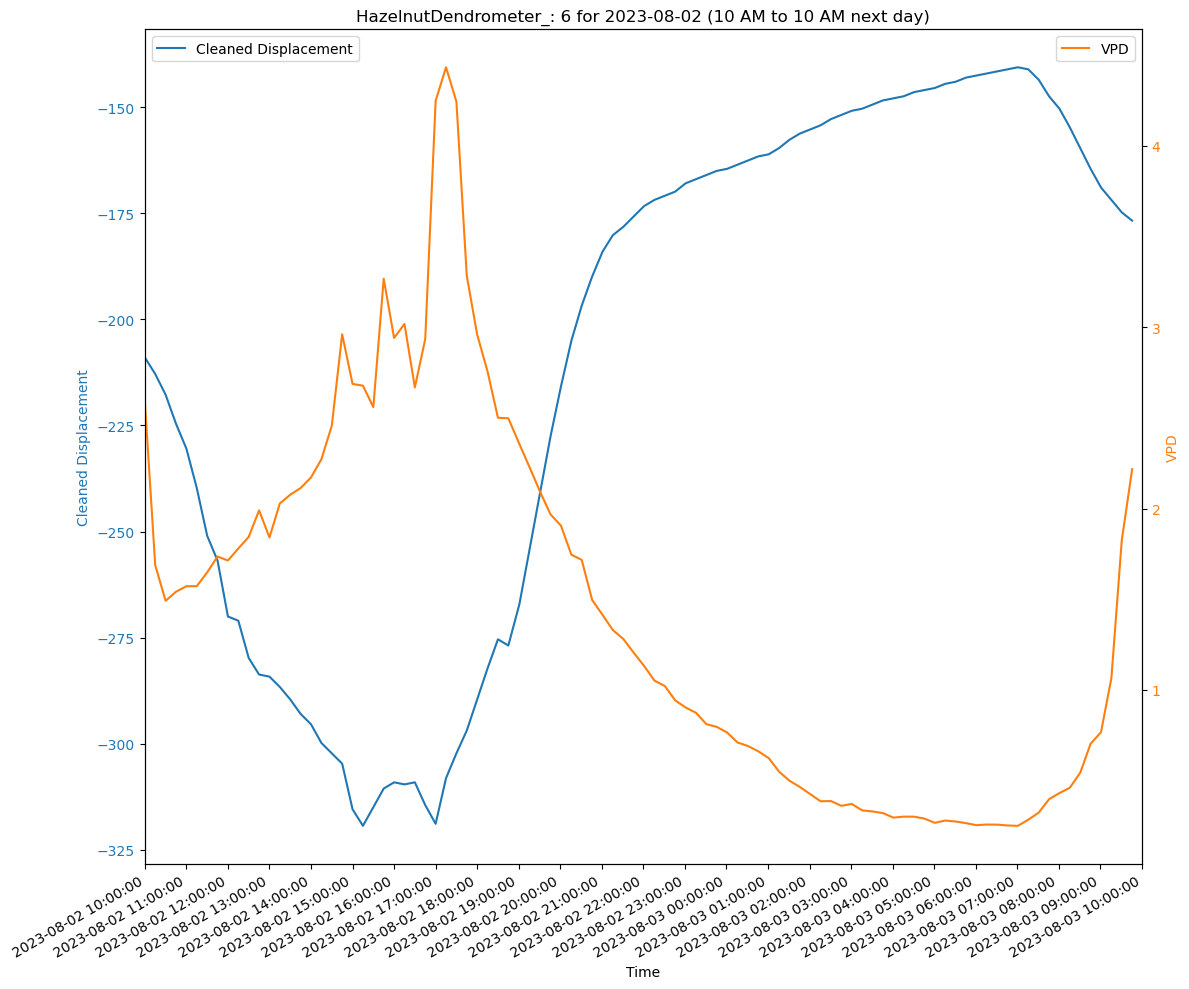

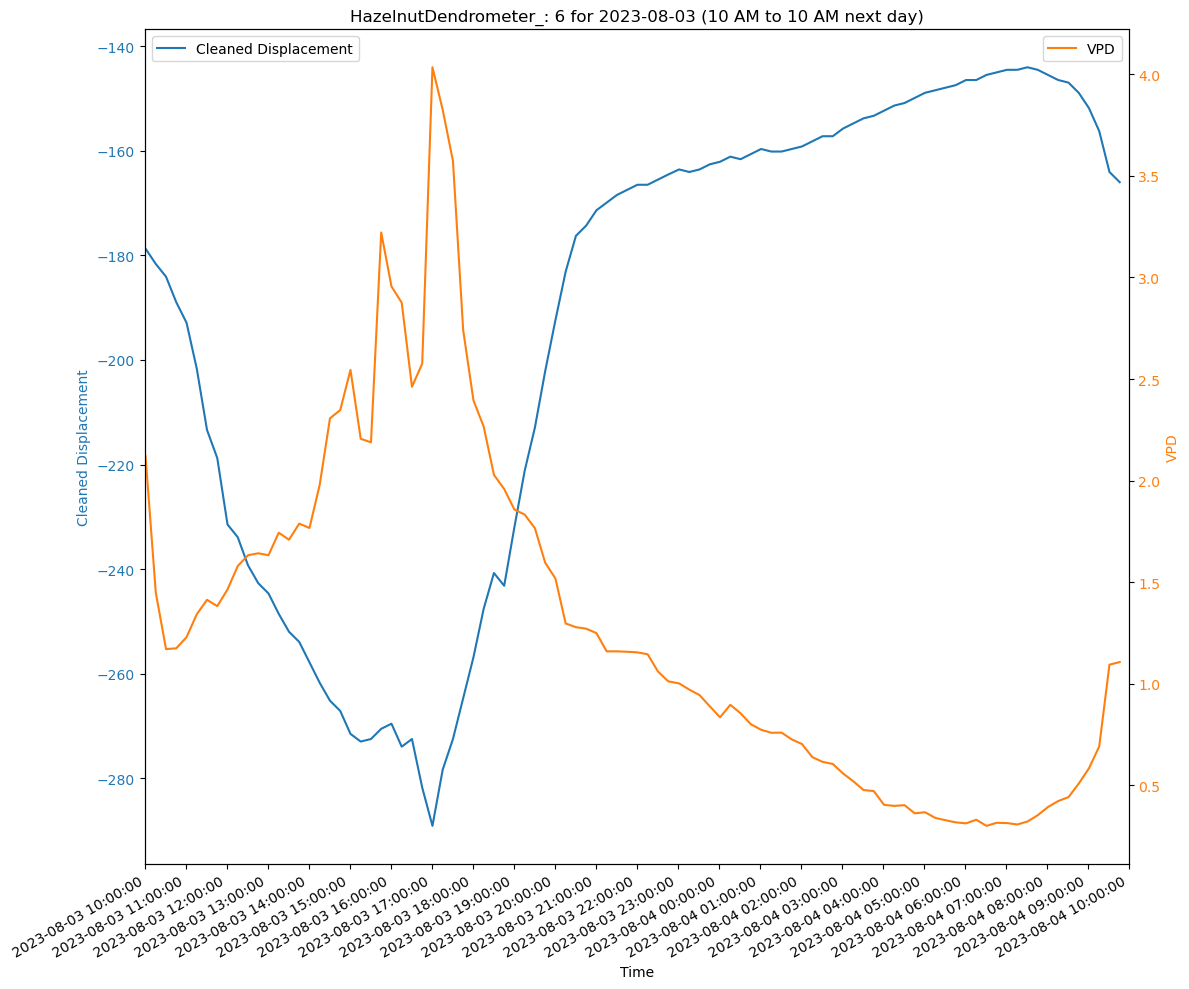

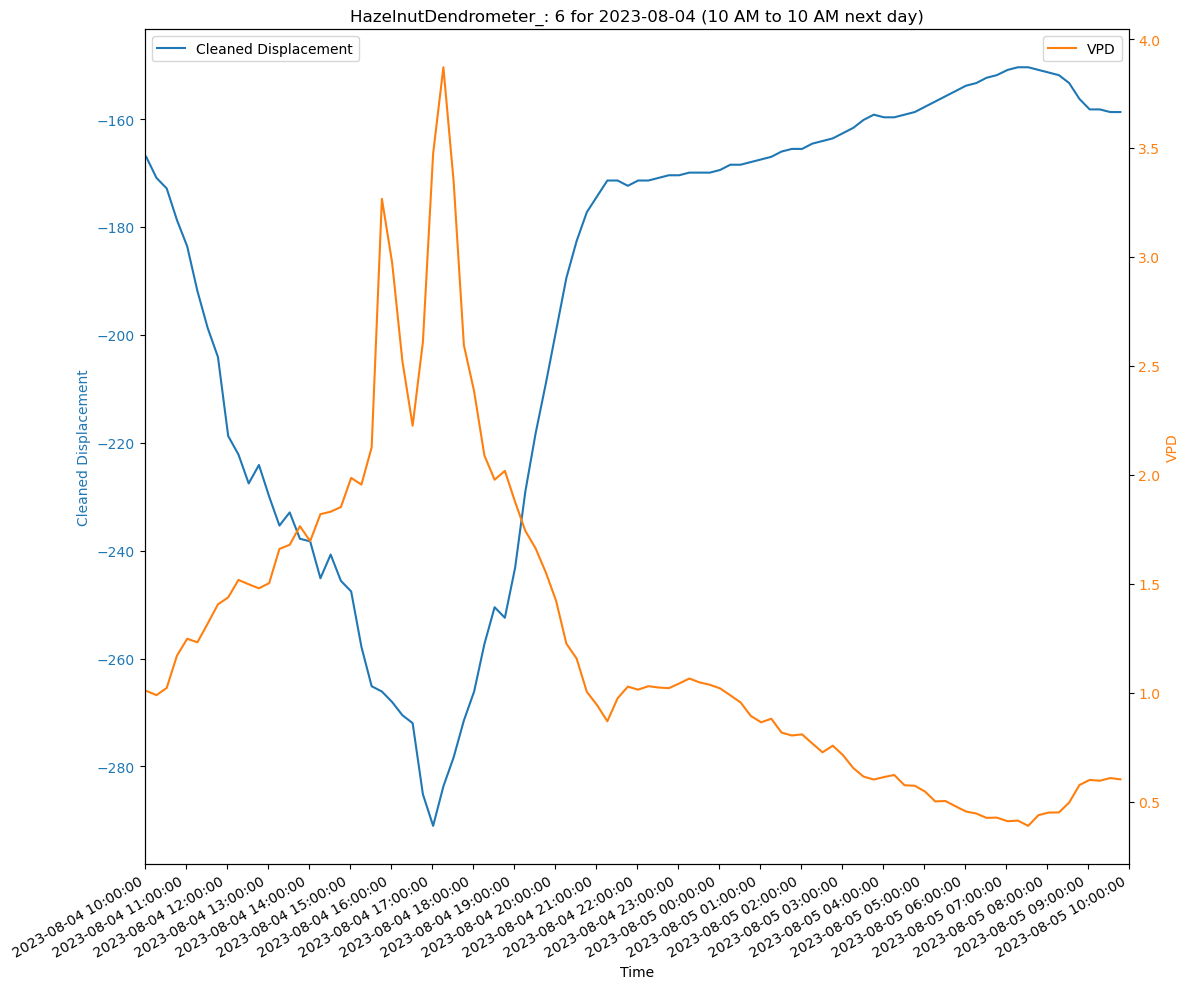

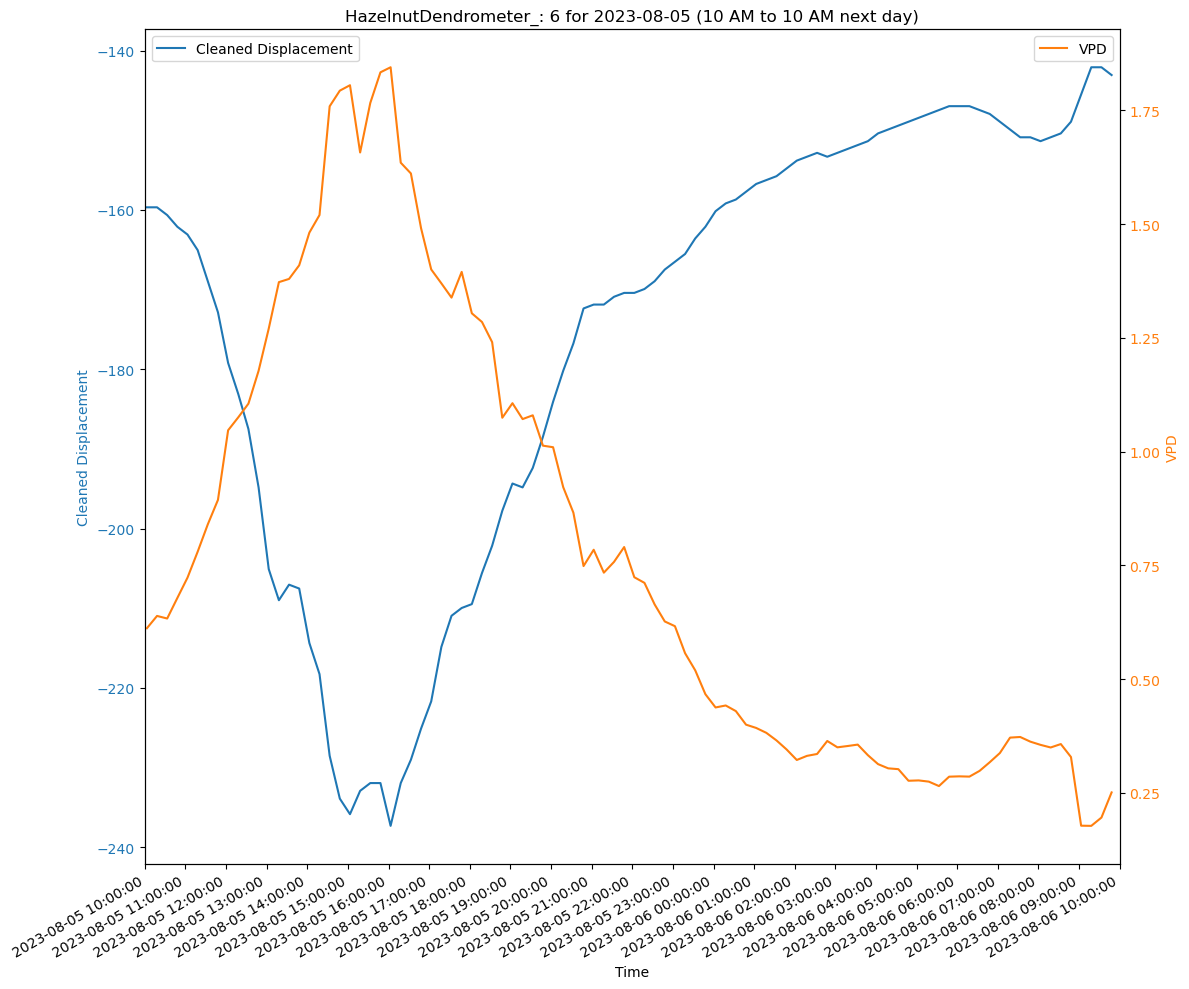

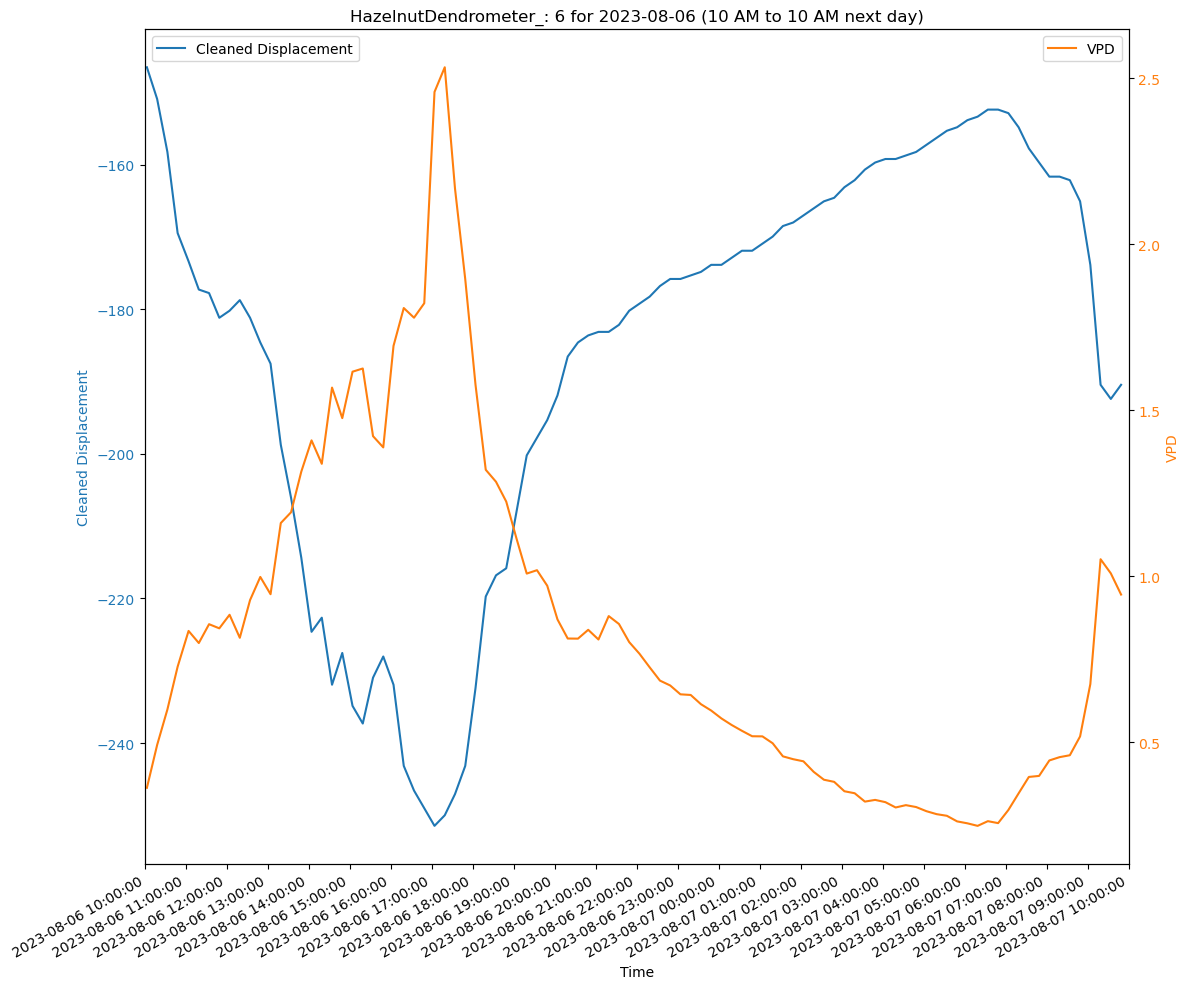

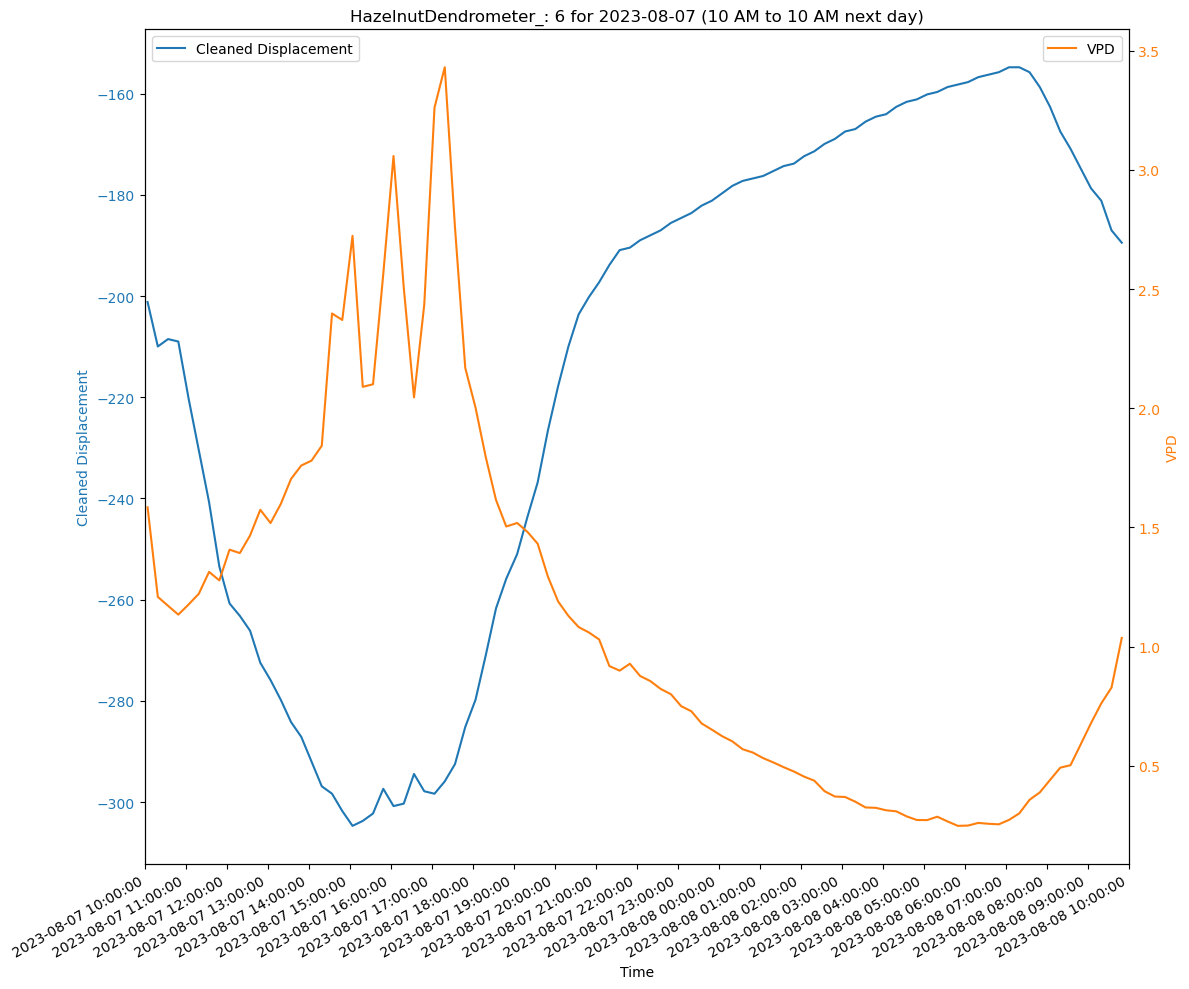

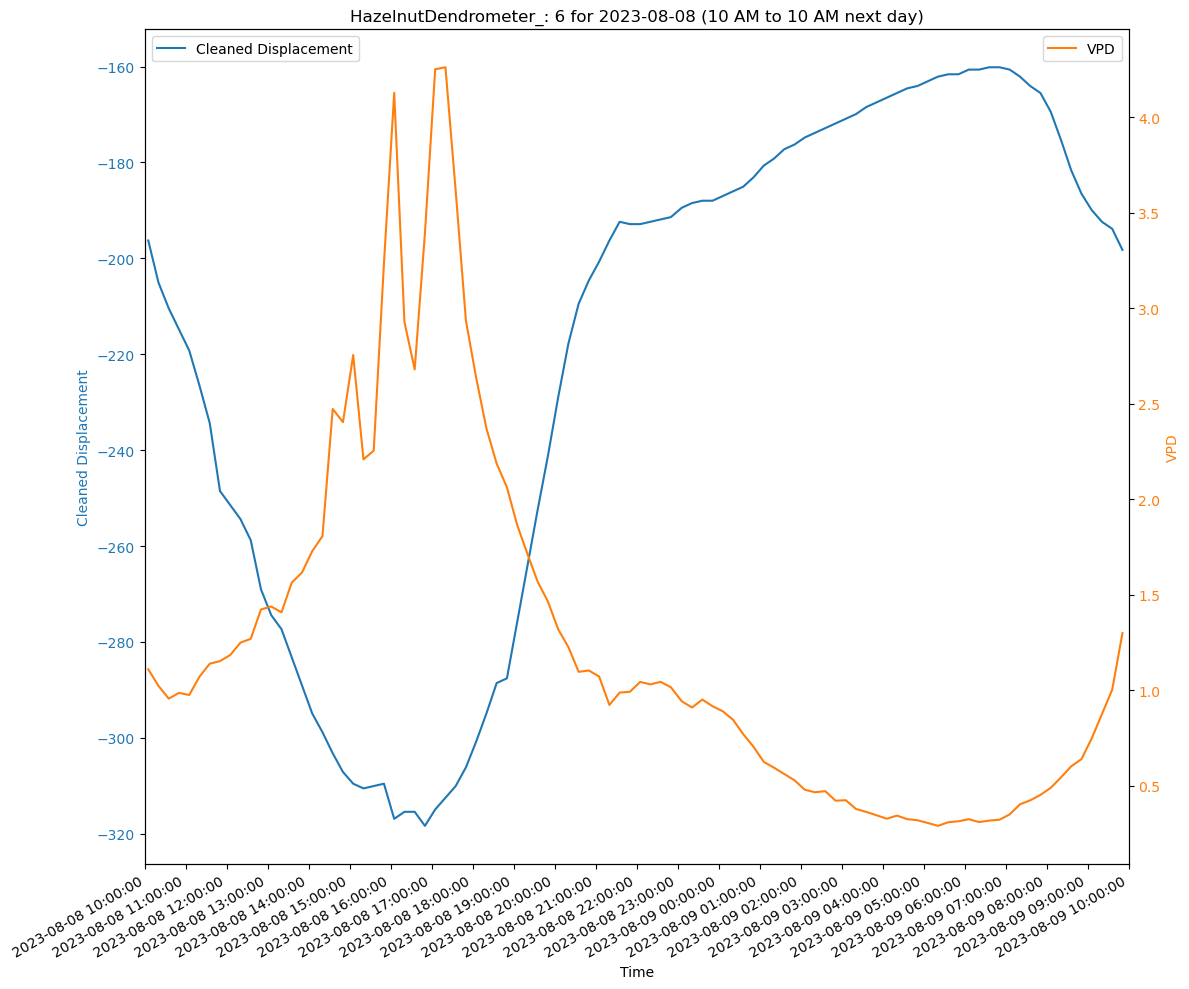

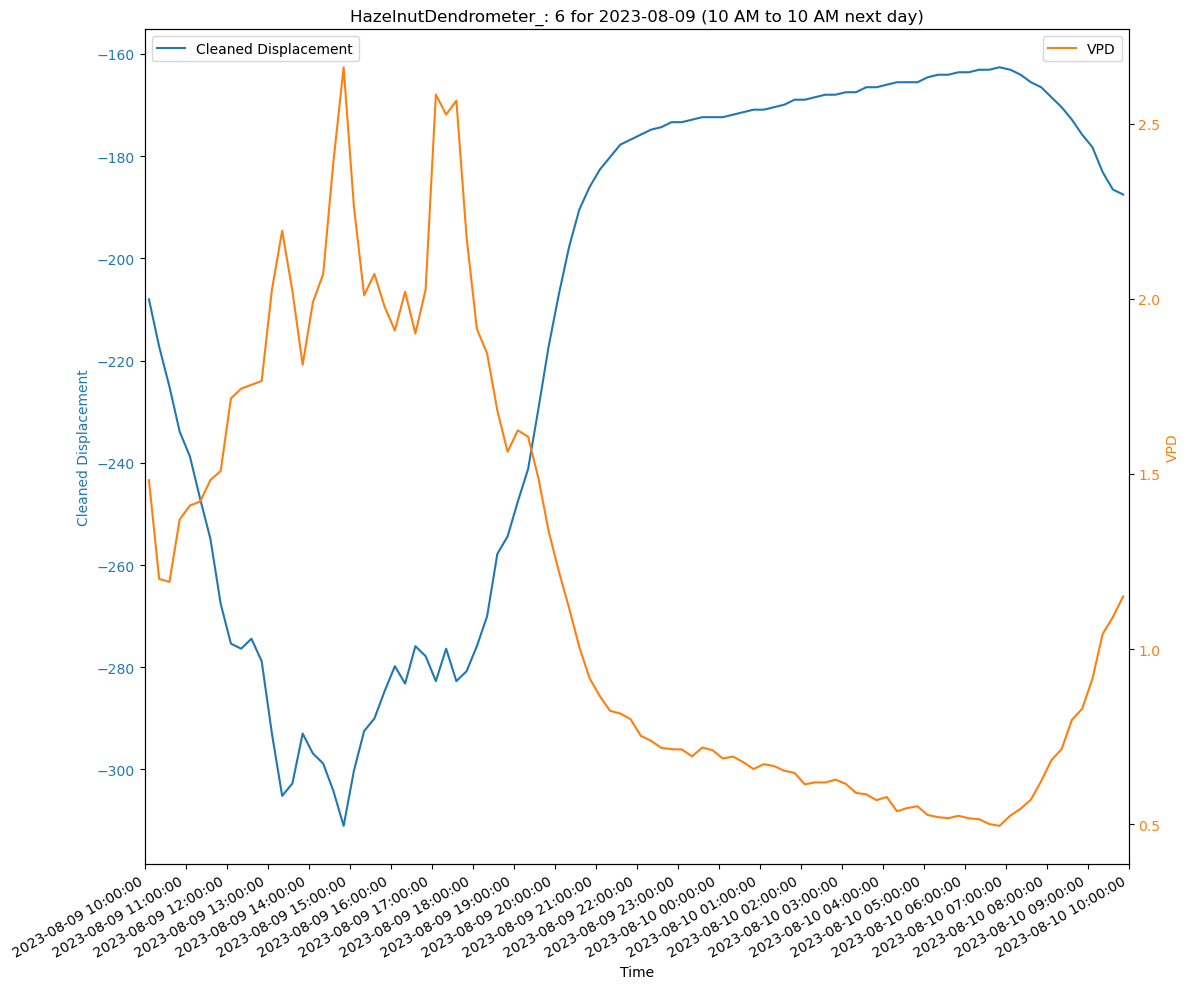

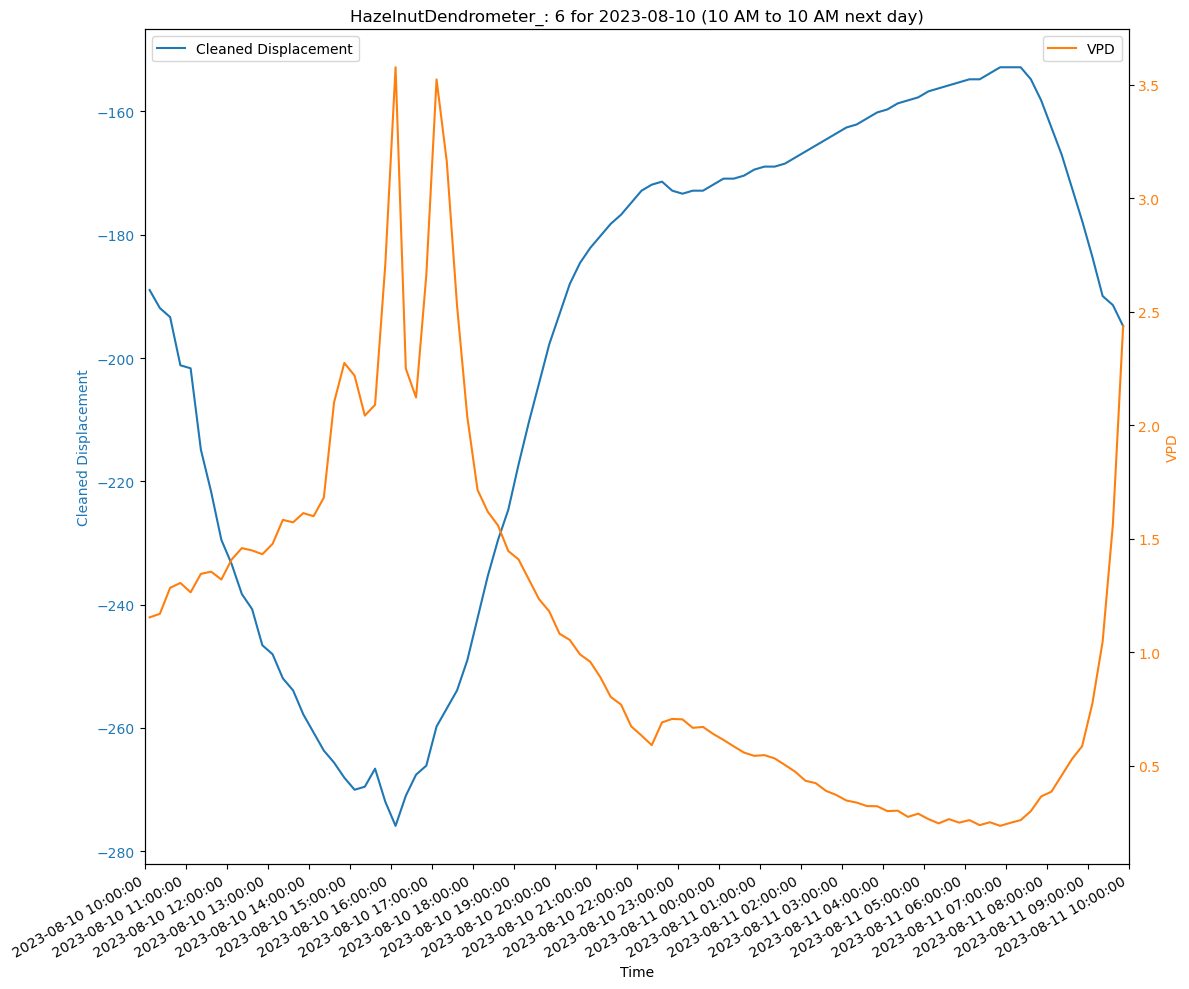

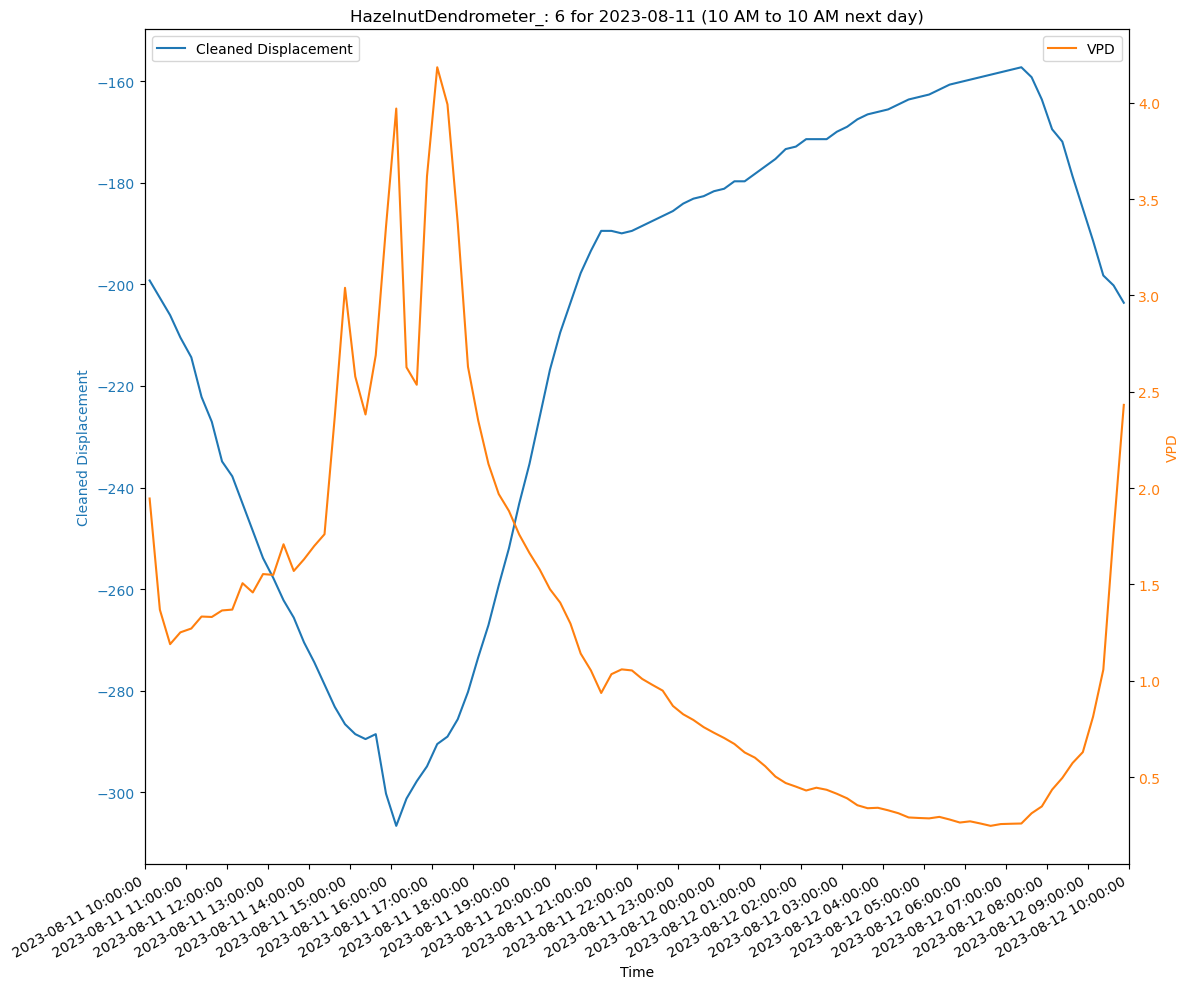

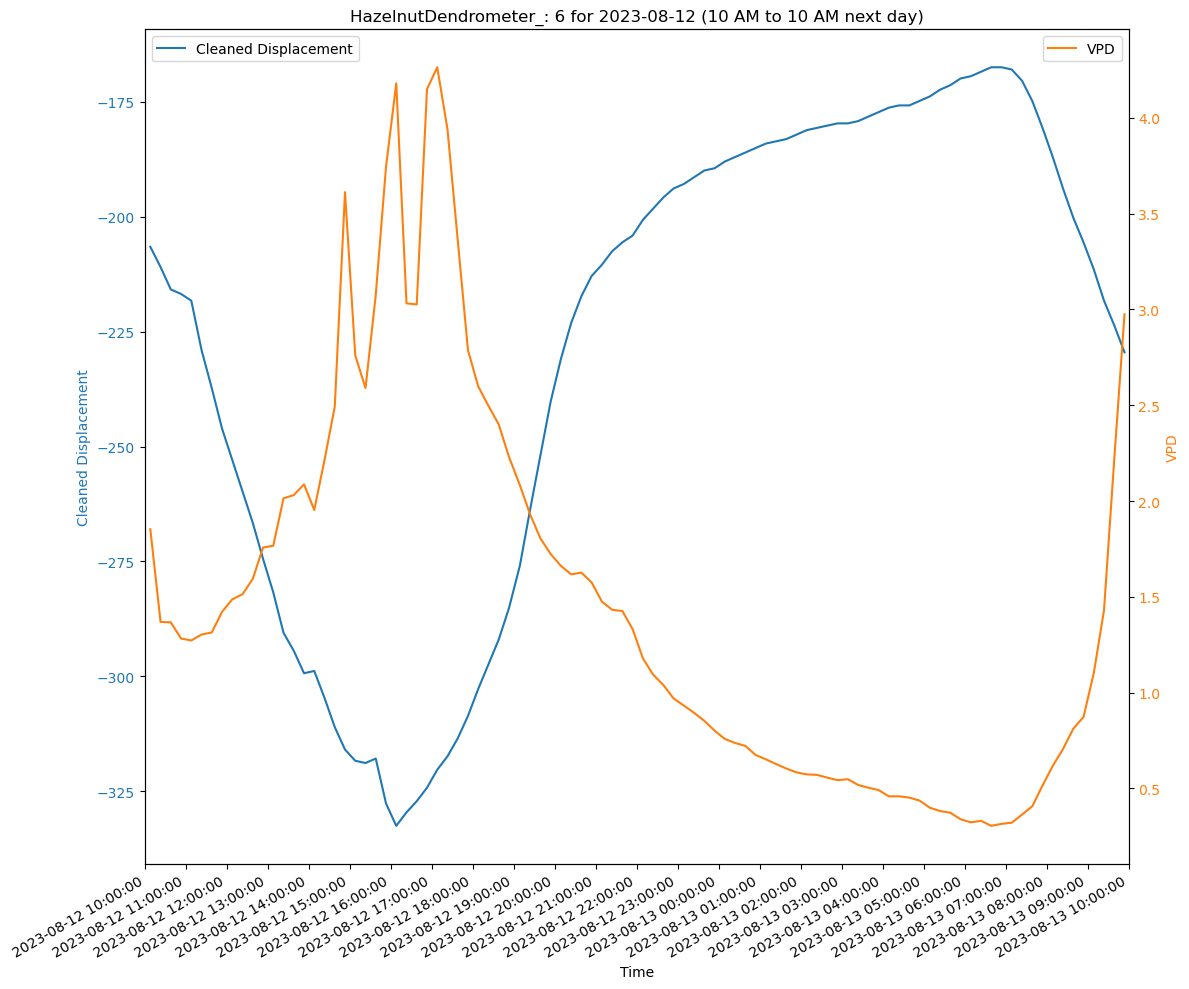

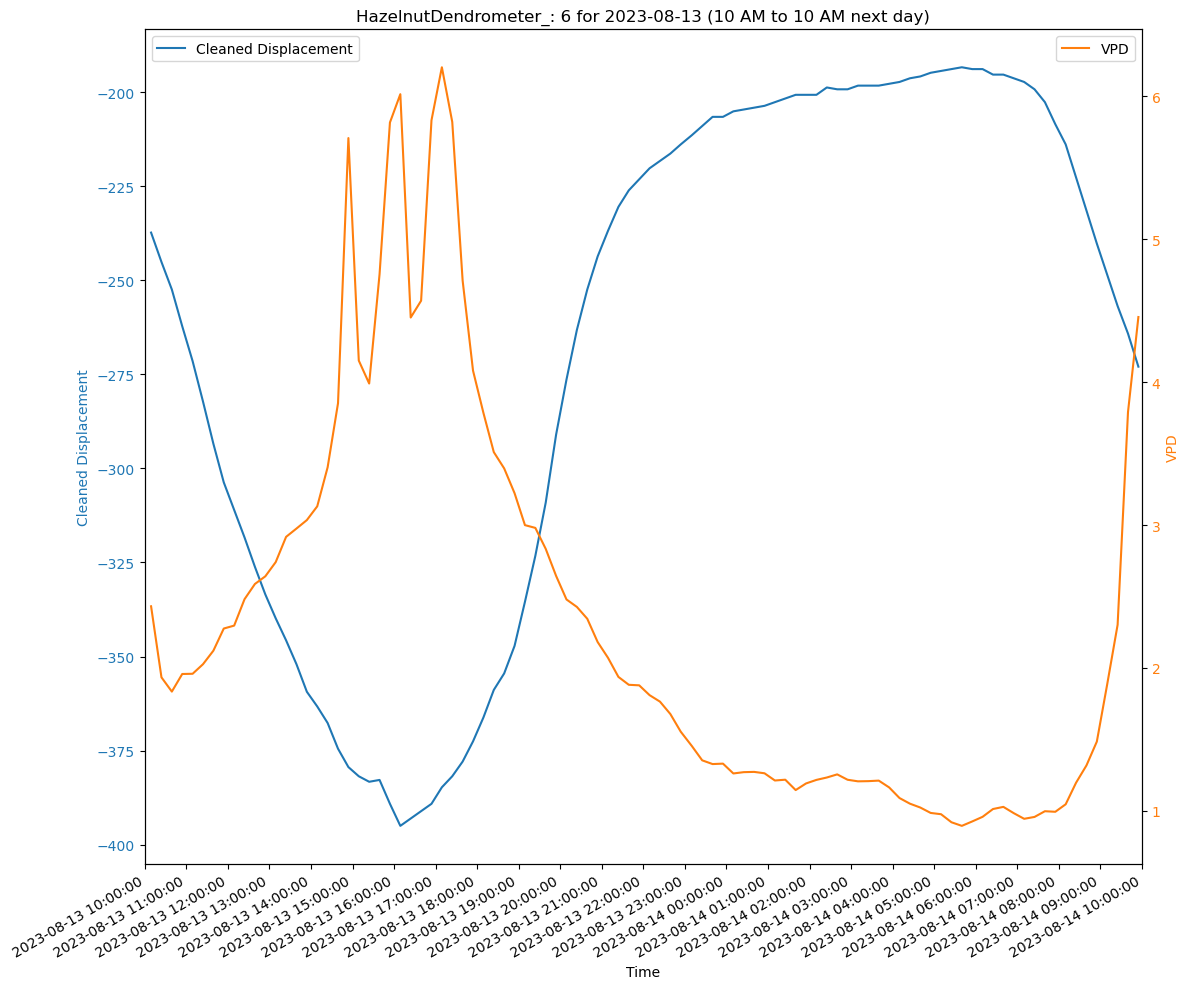

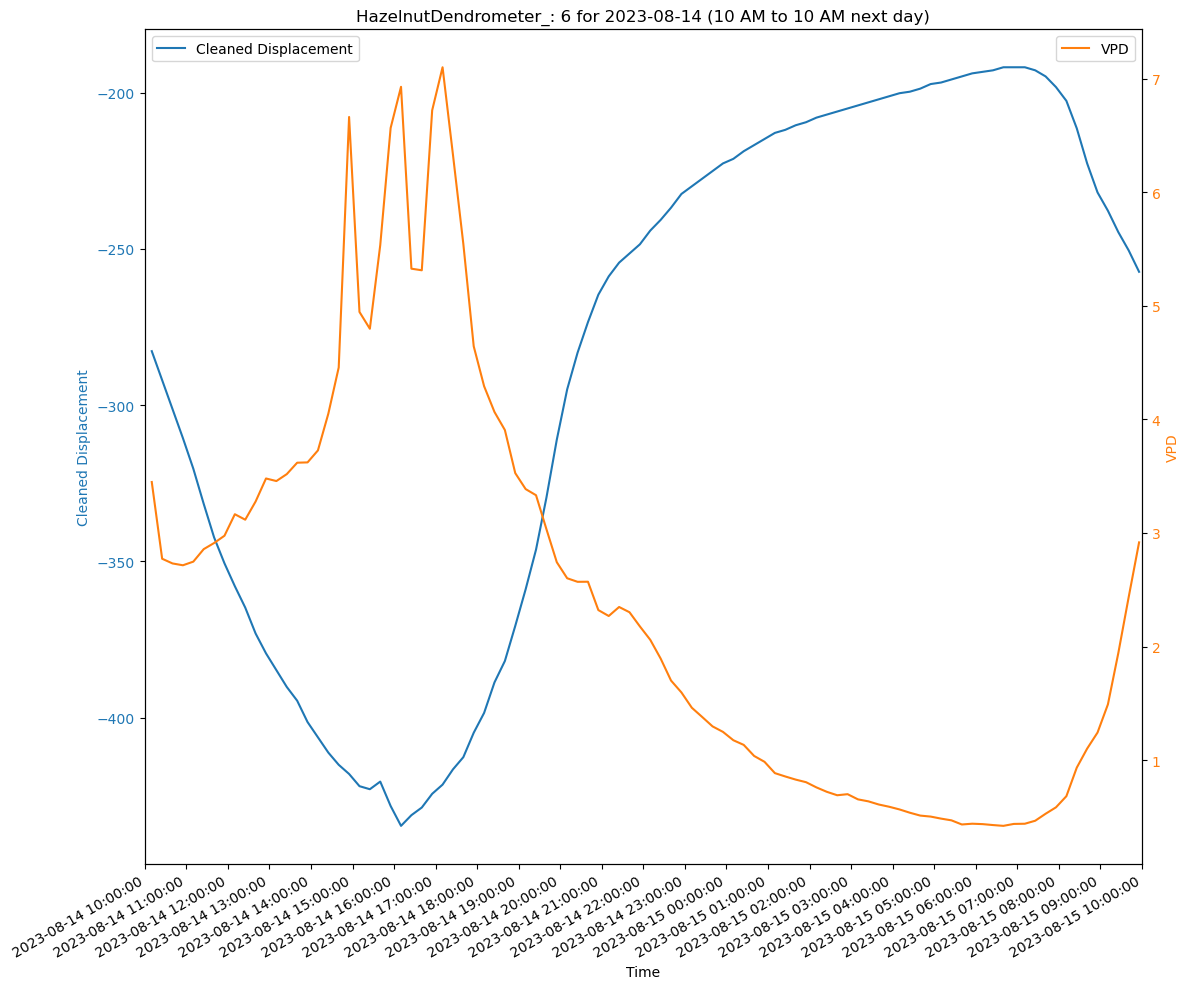

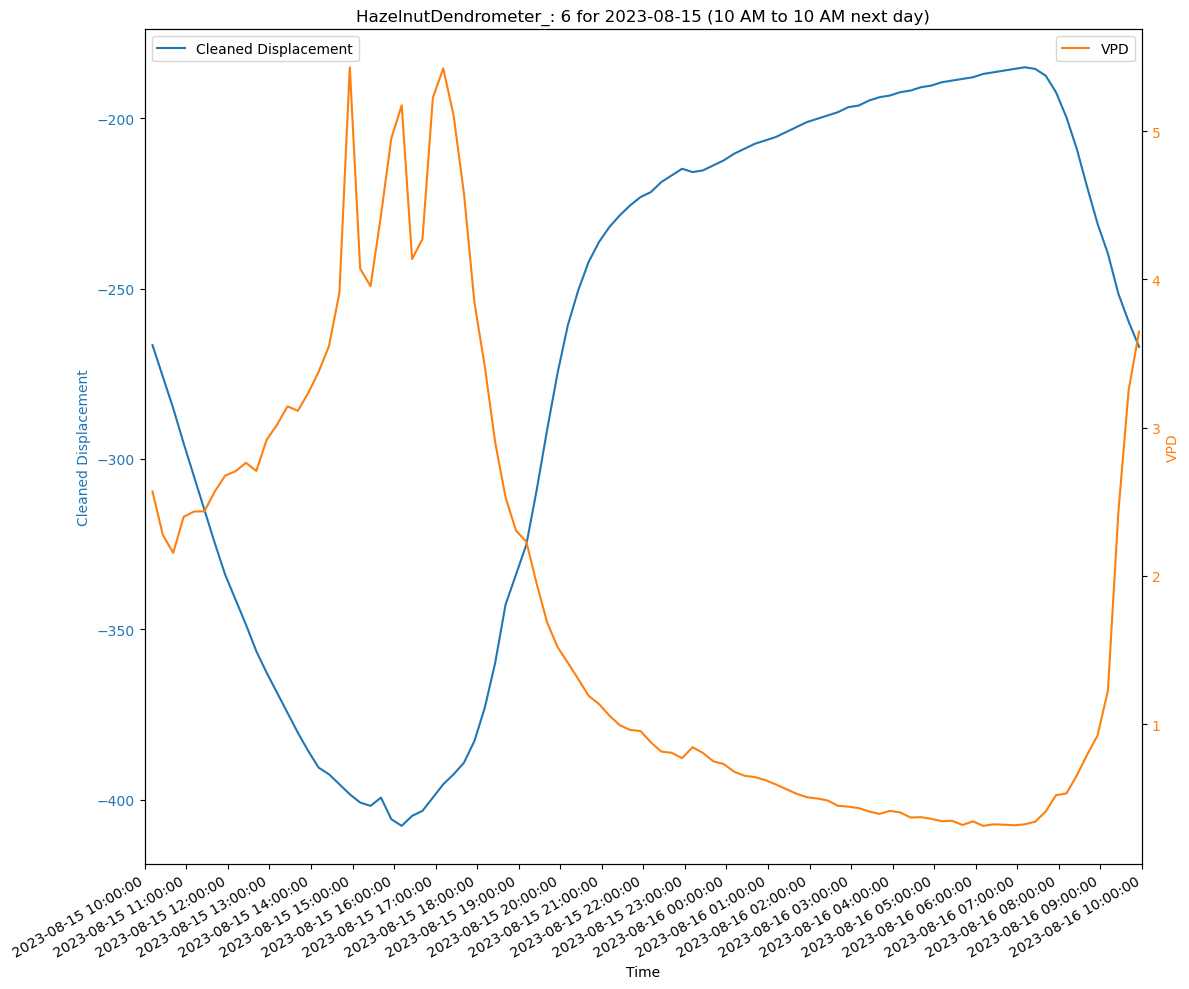

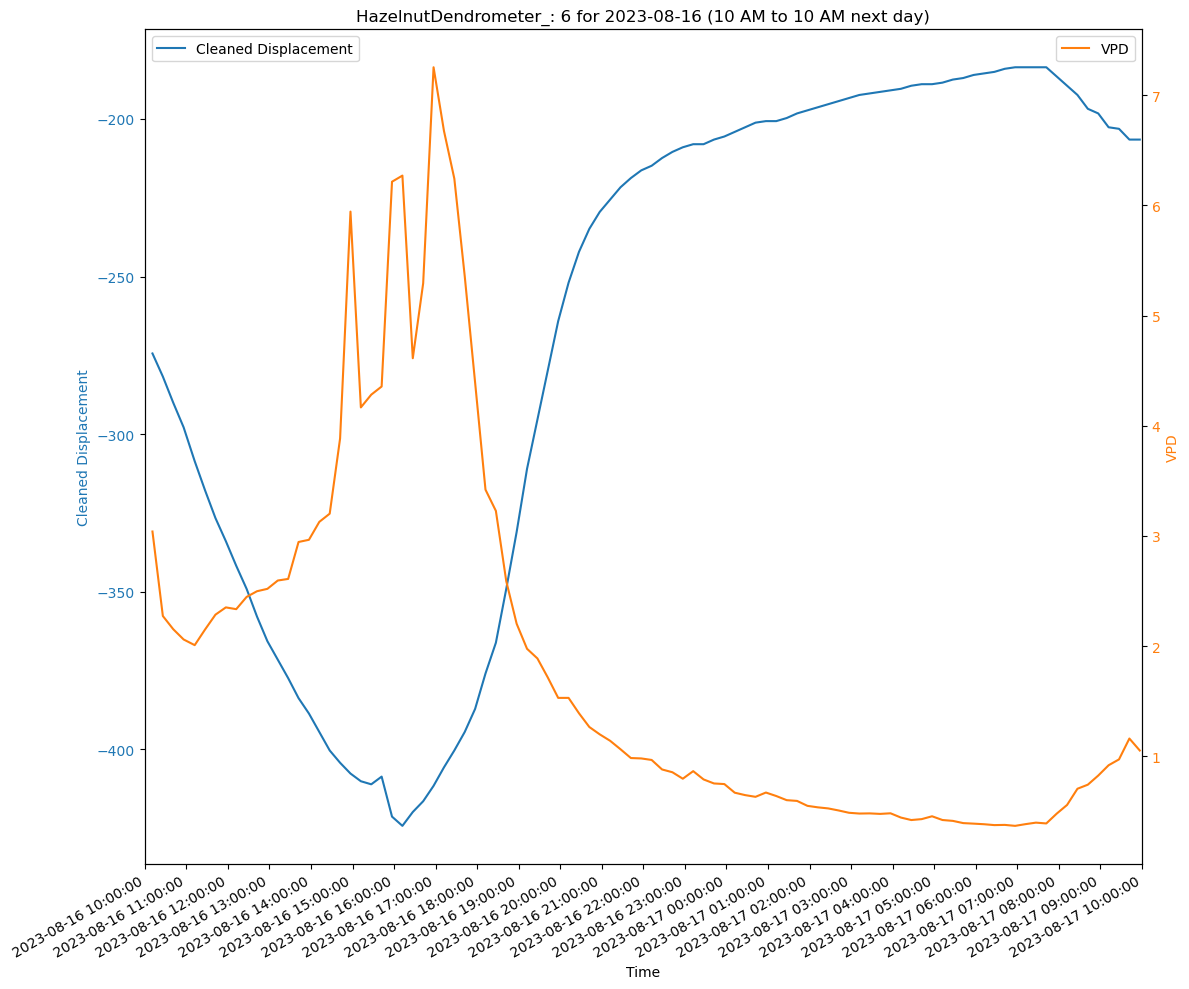

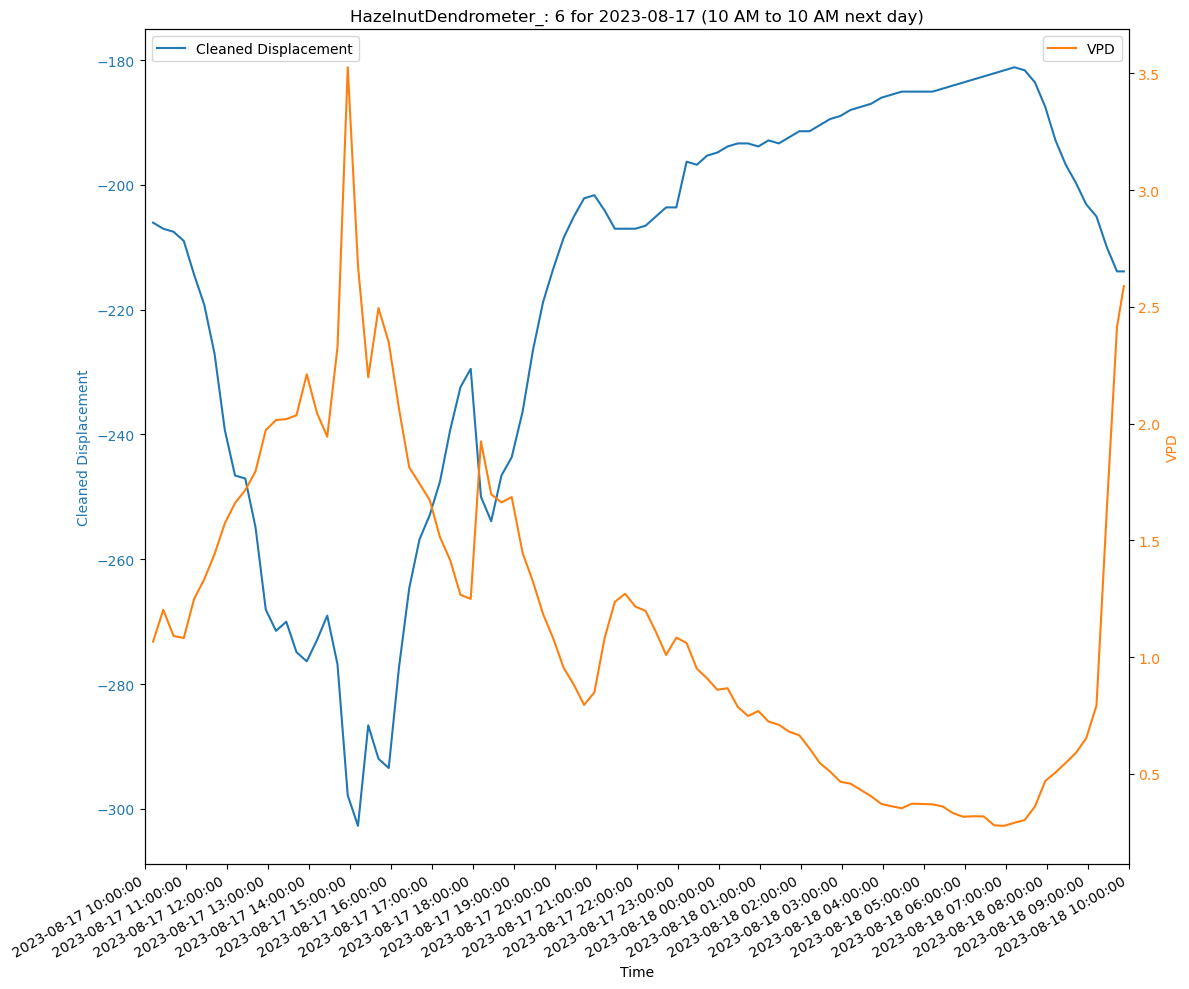

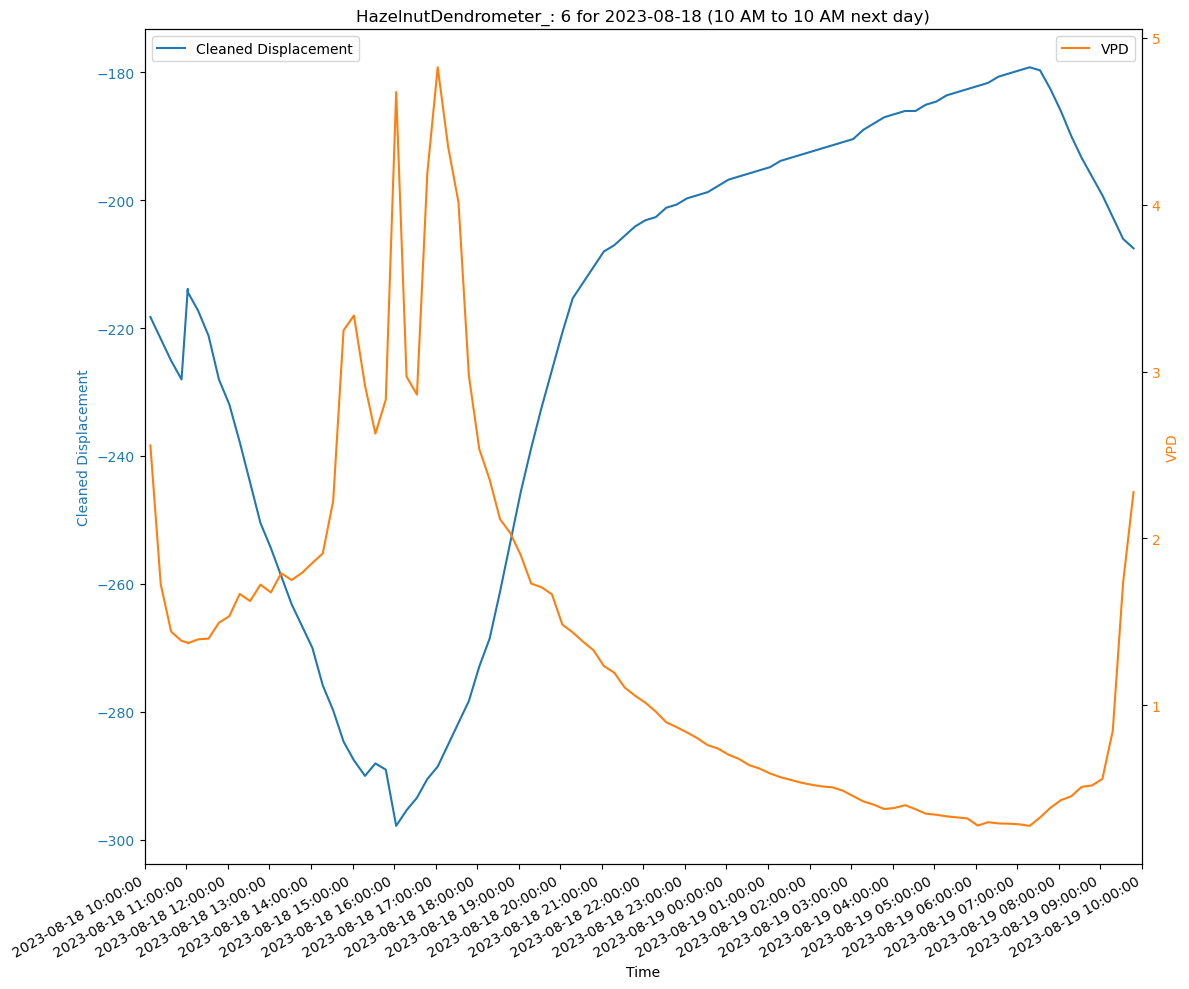

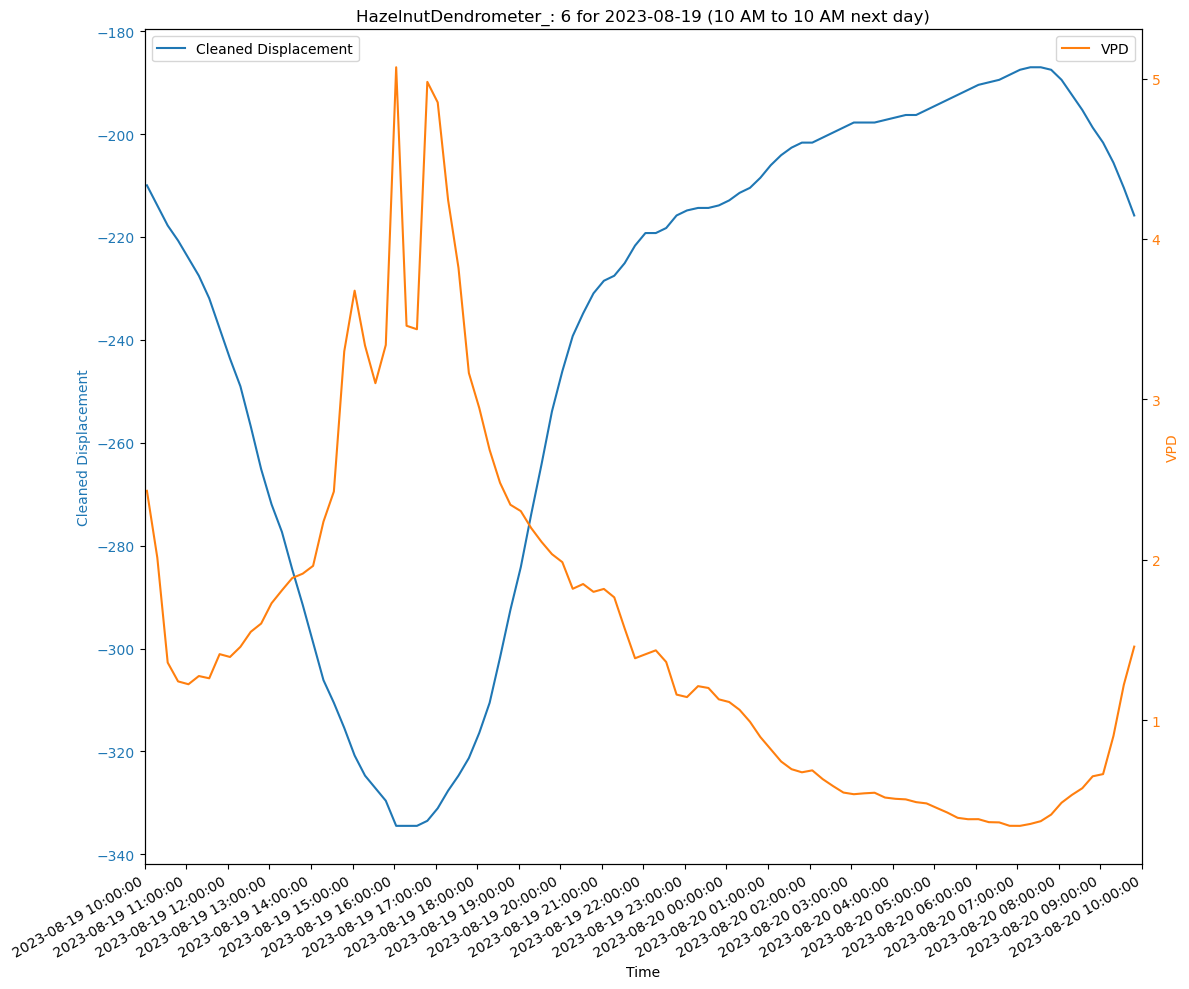

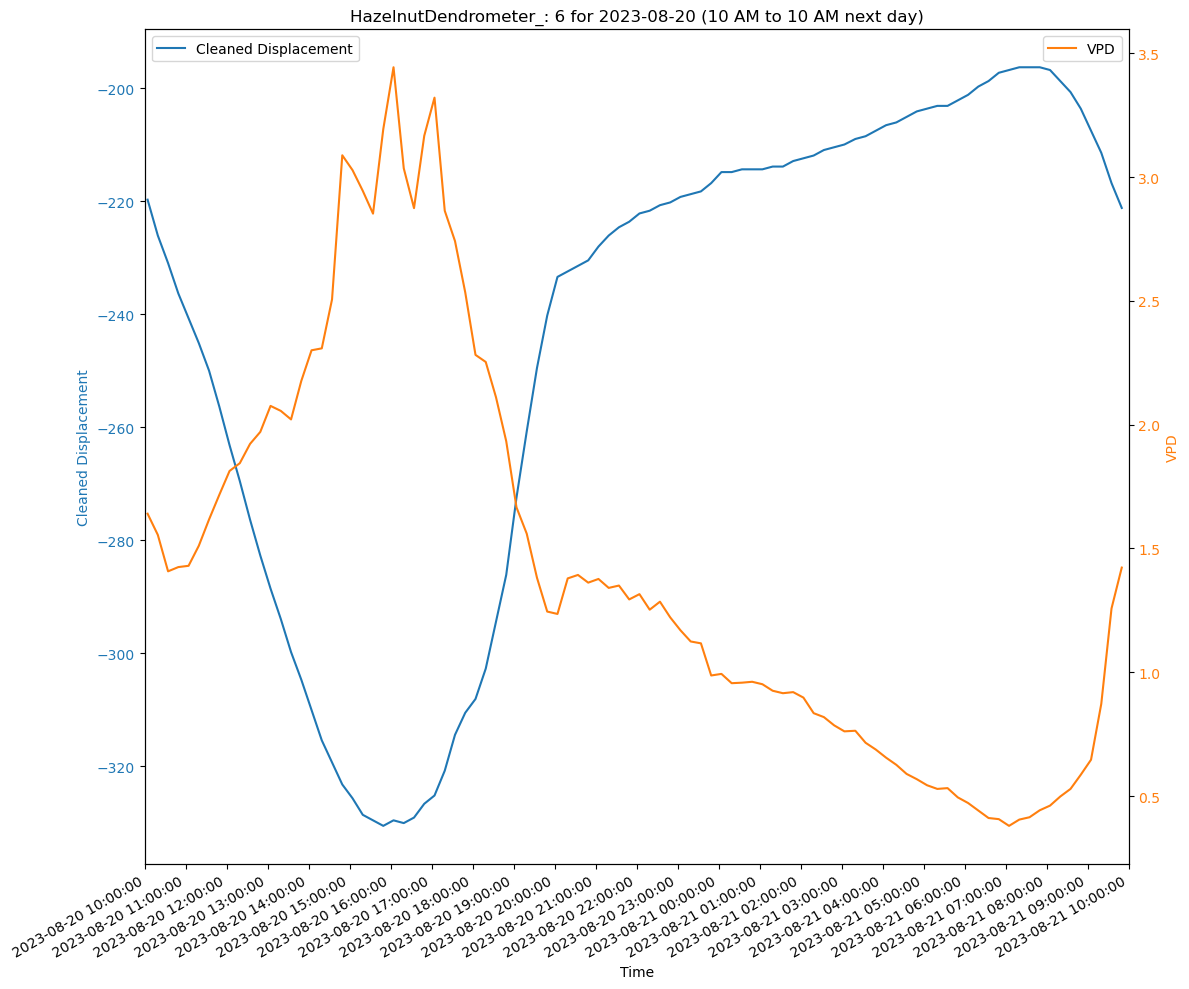

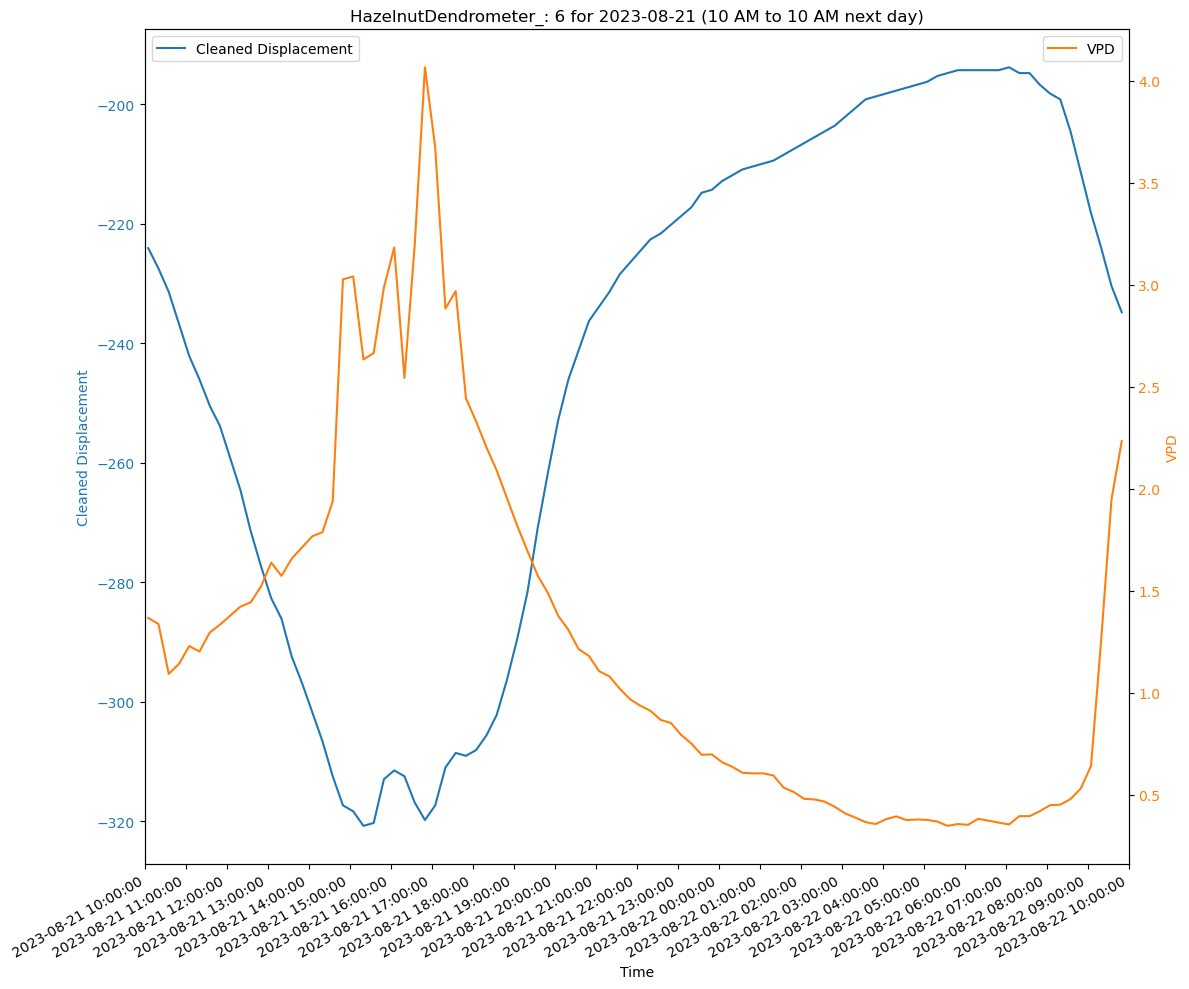

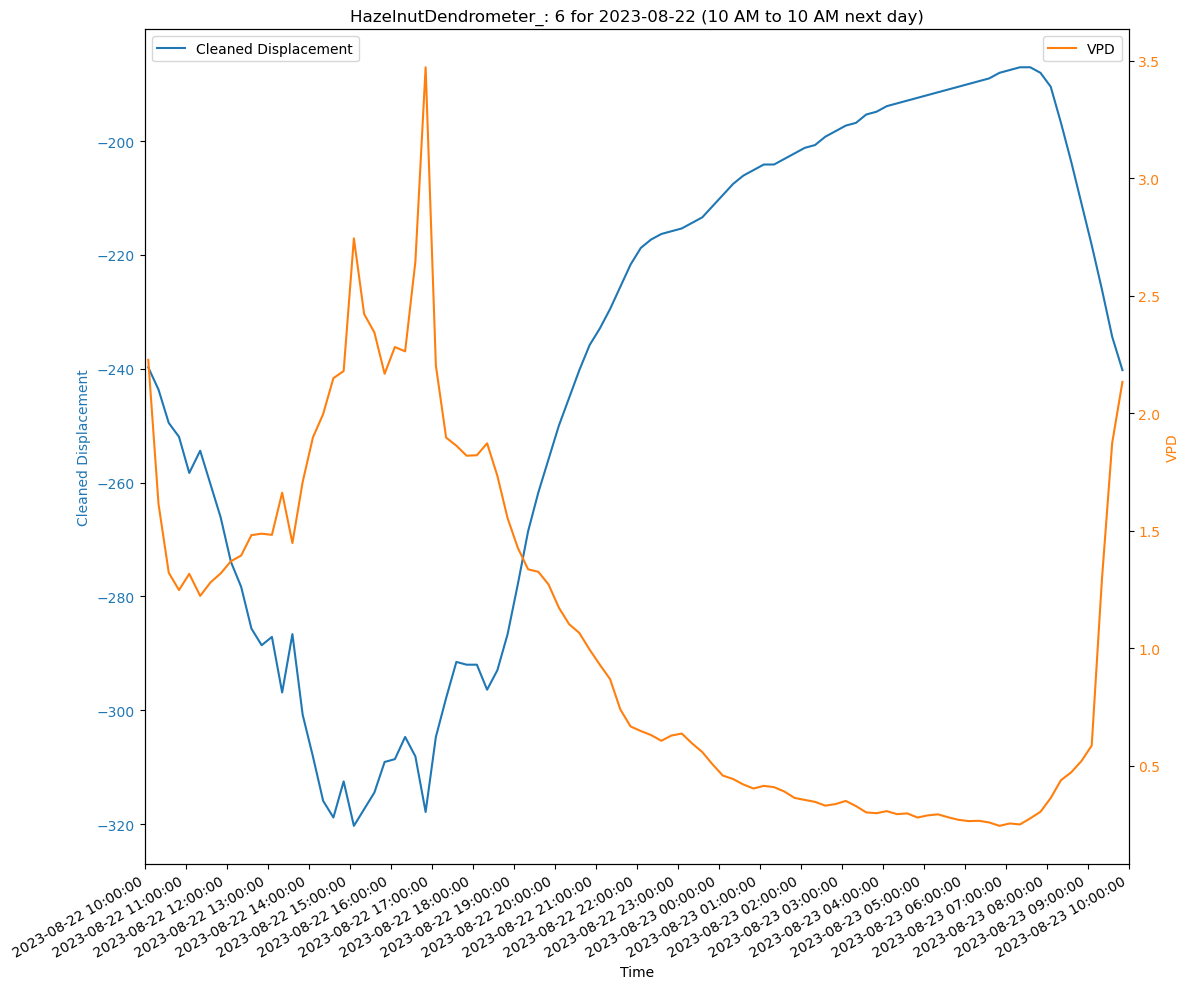

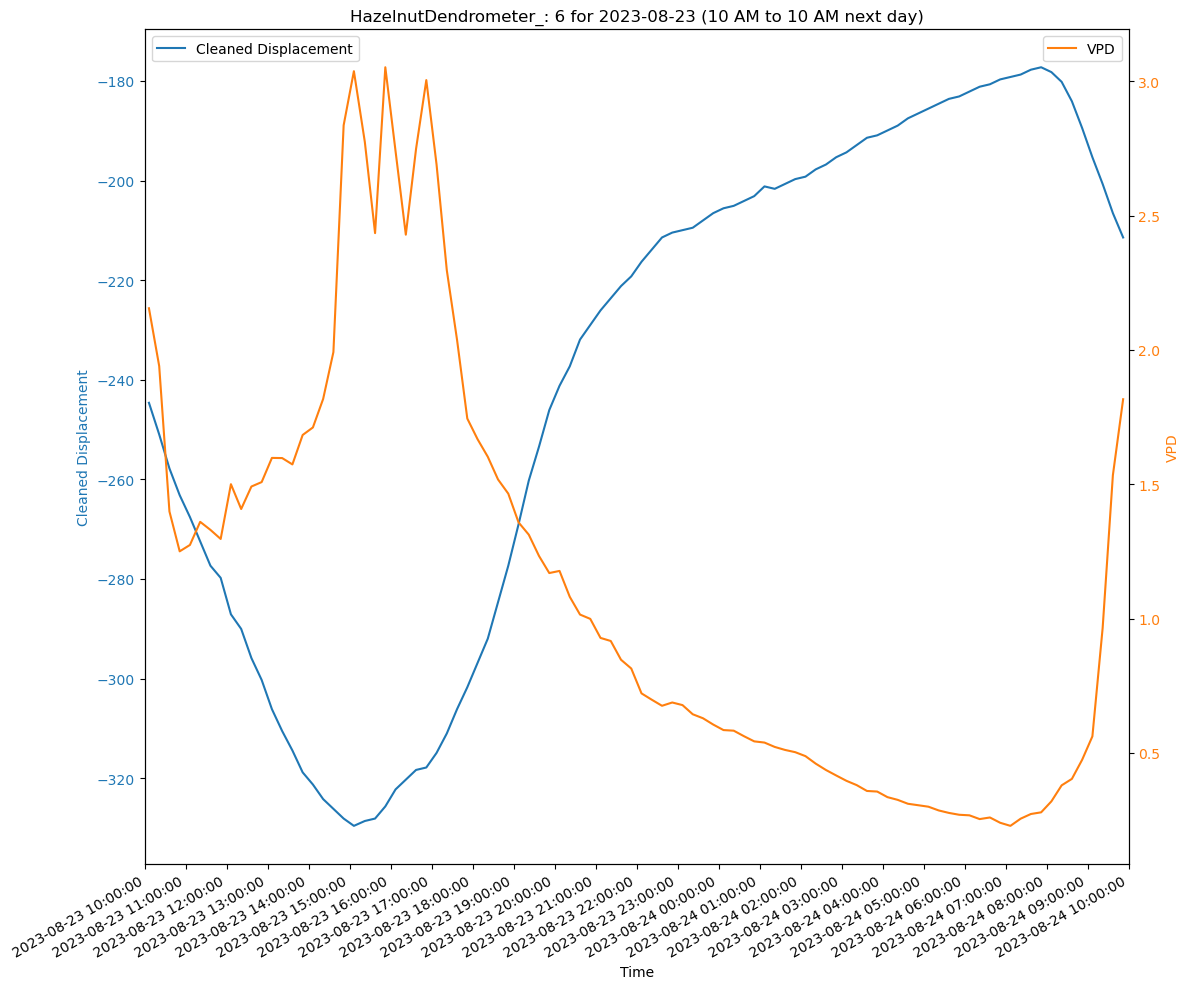

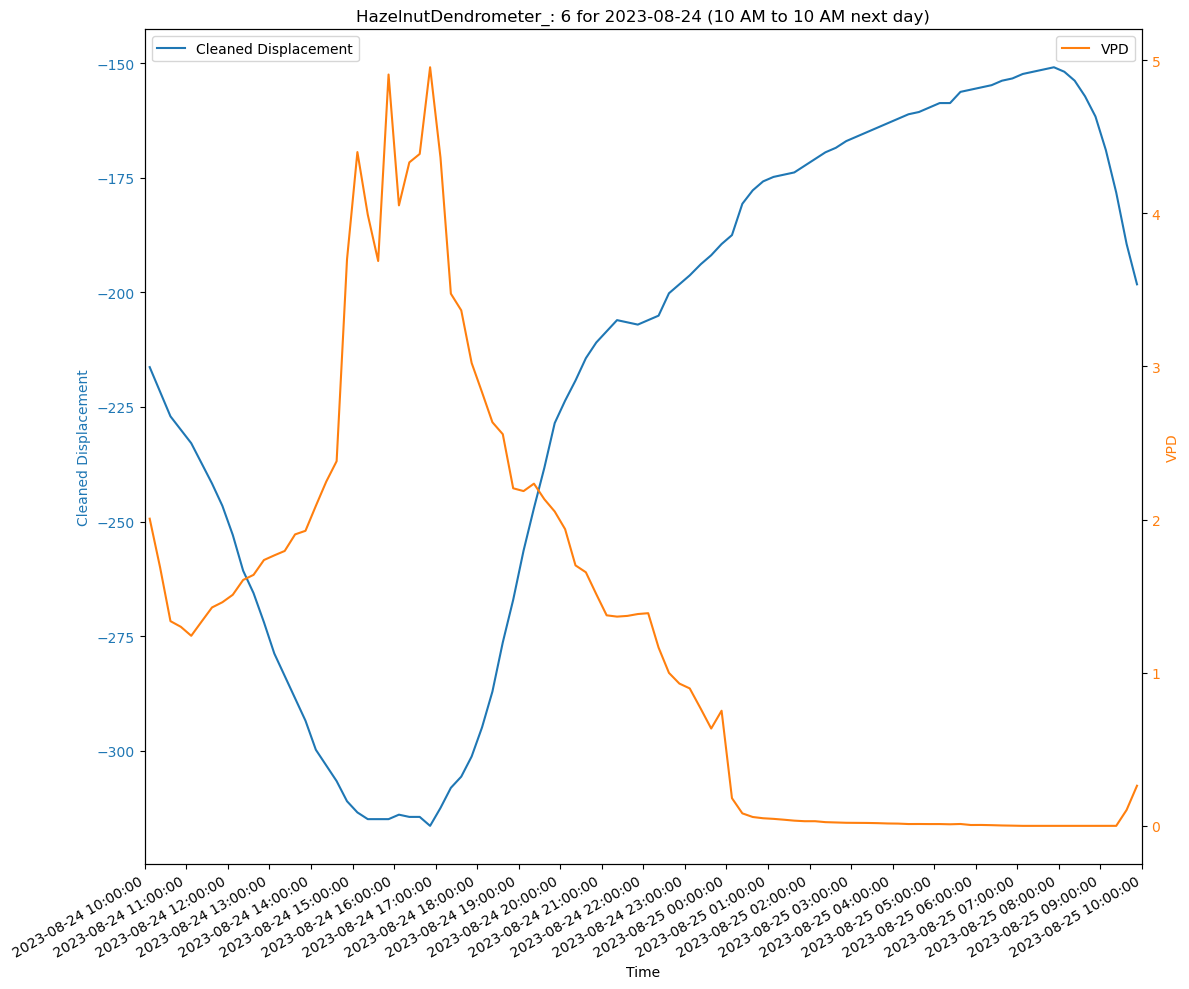

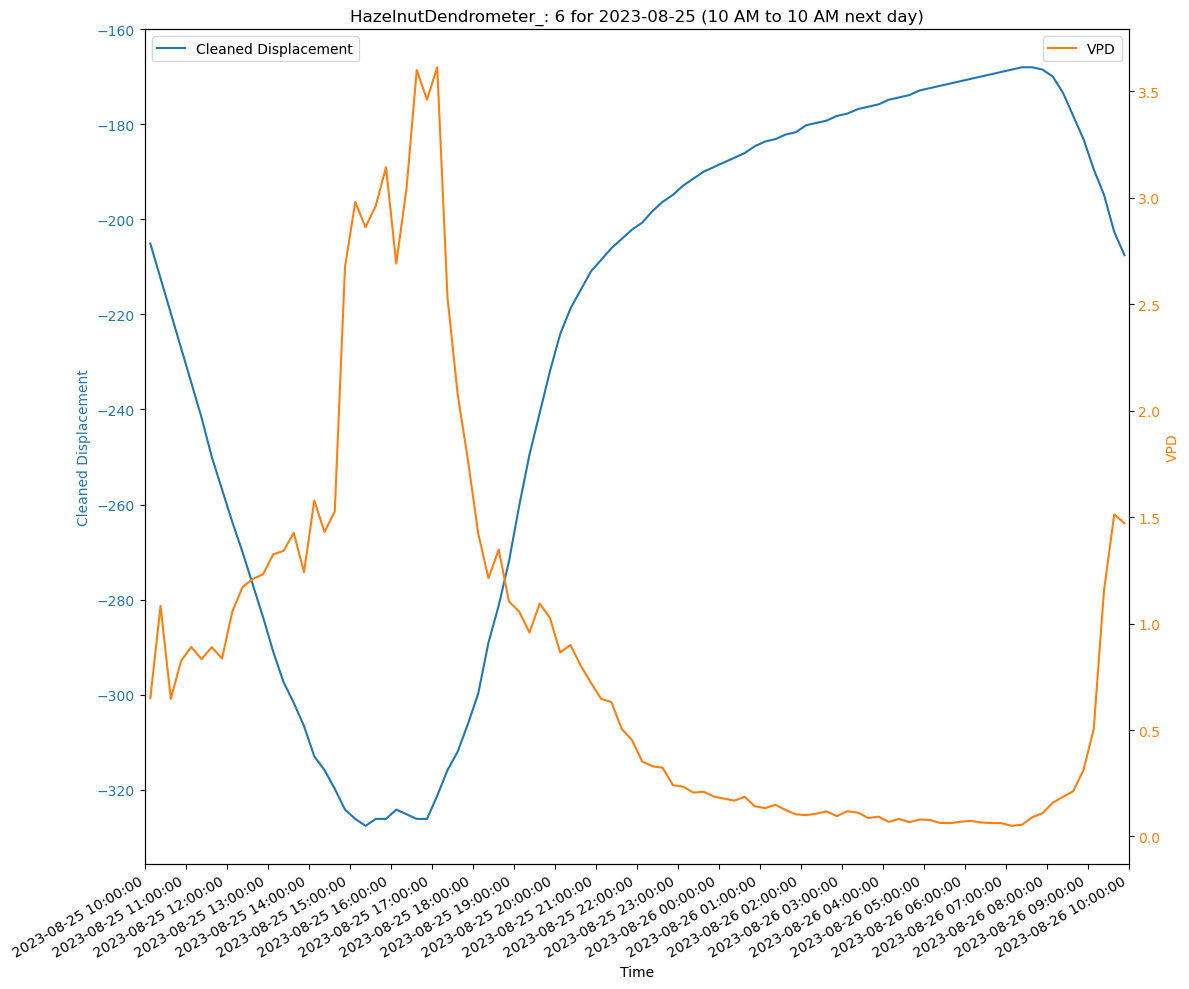

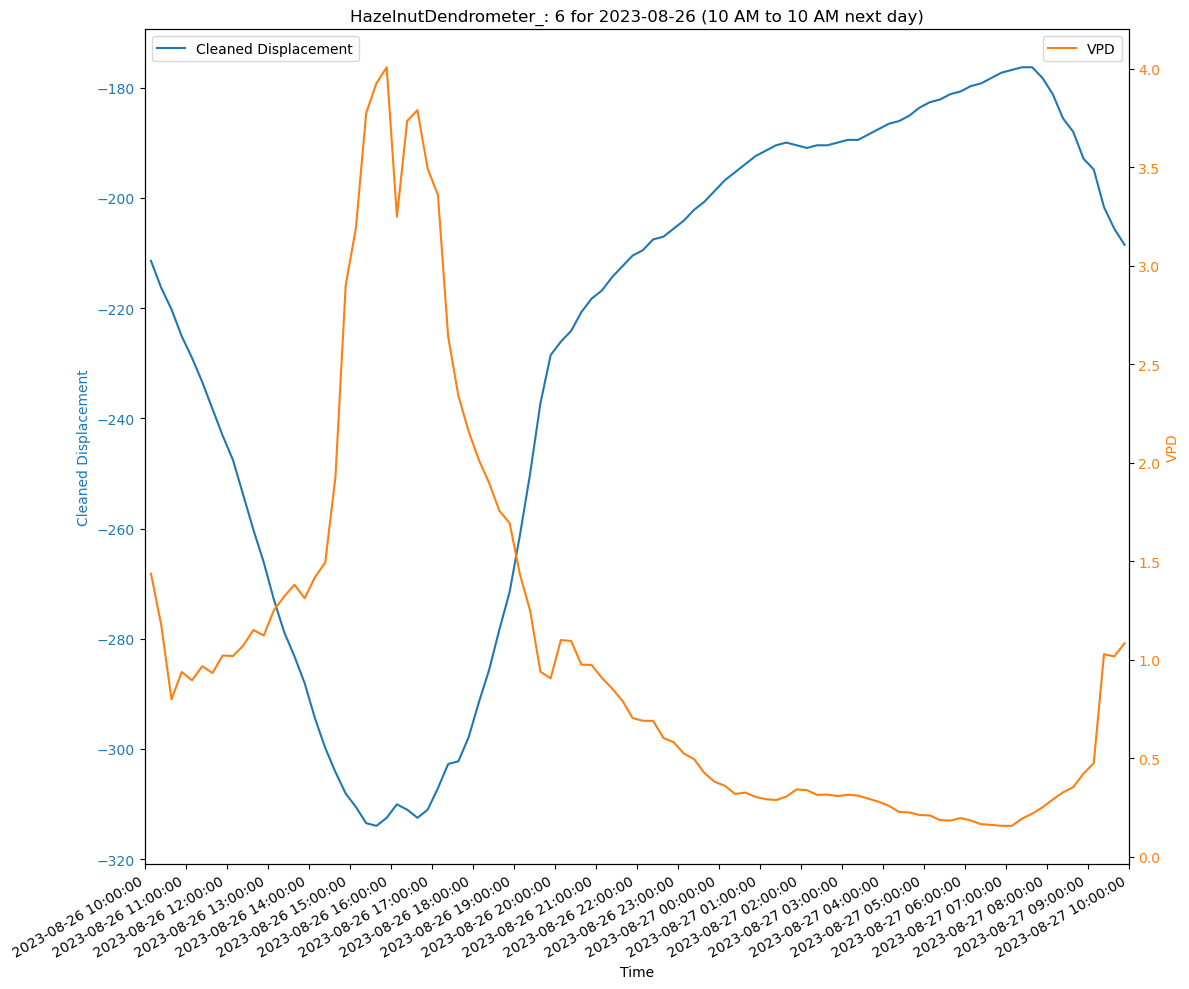

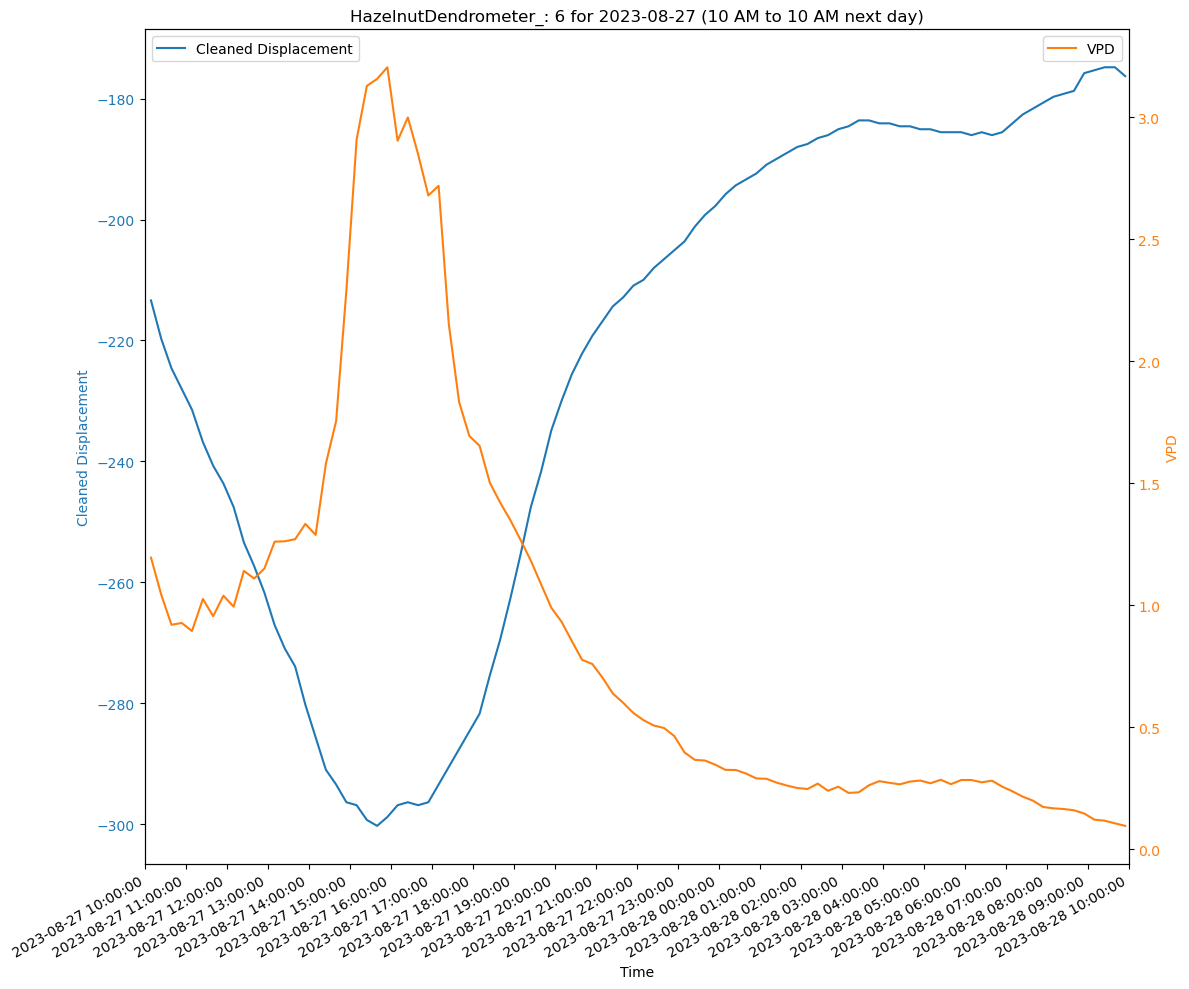

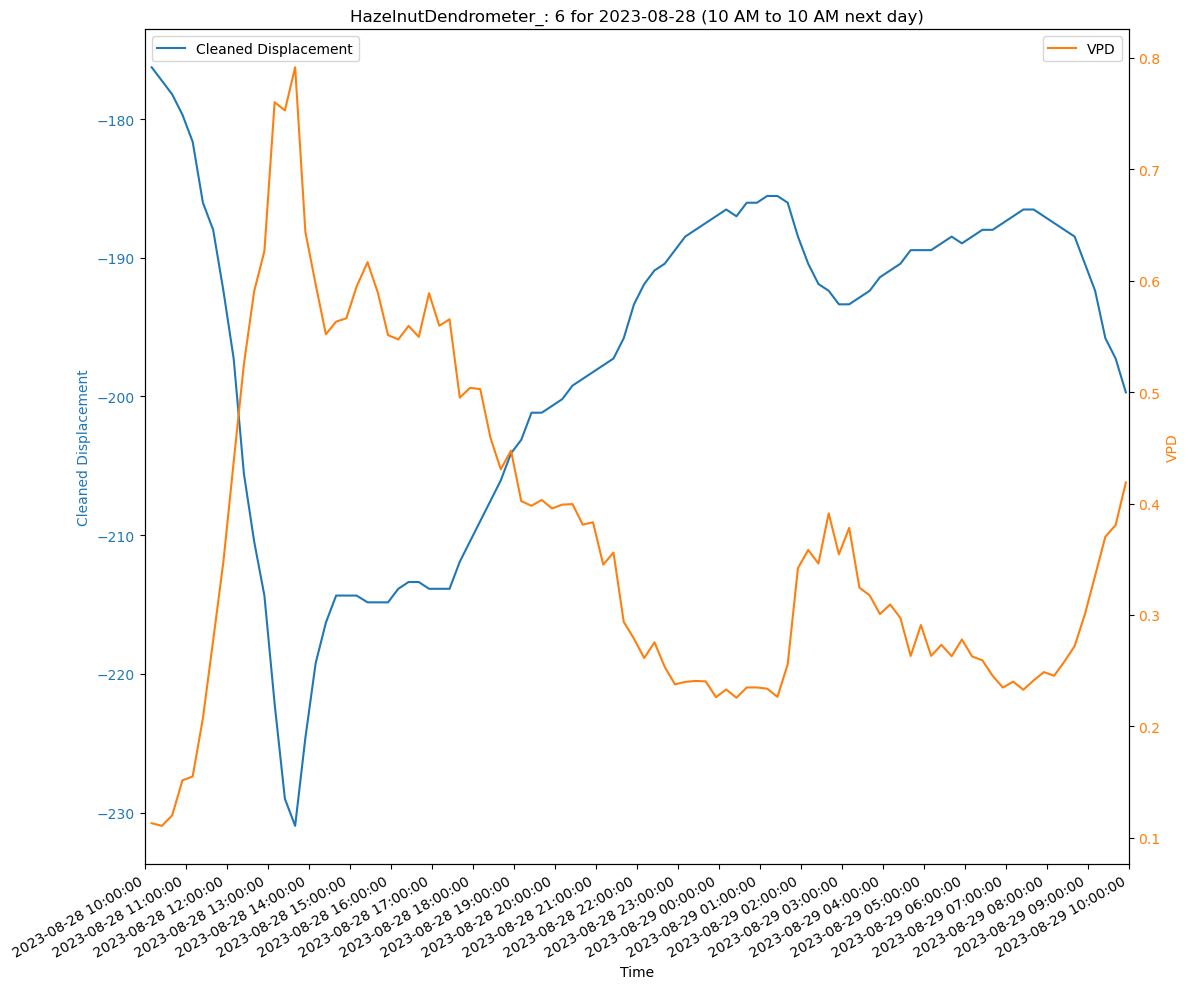

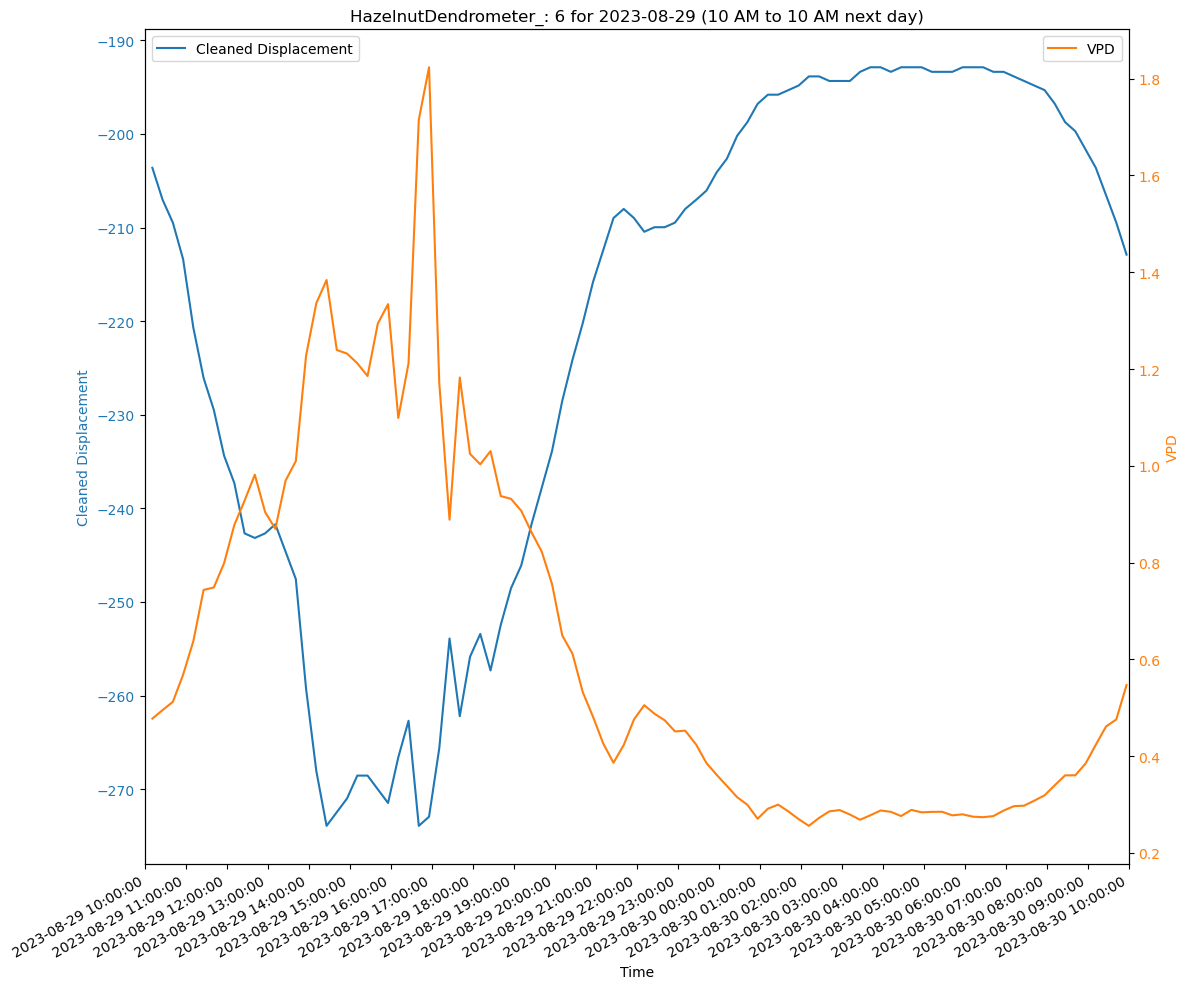

In [ ]:
#Plot with VPD
def plot_24hr_intervals(cleaned_df, device_name):
    min_date = cleaned_df['time_local'].min().strftime('%Y-%m-%d')
    max_date = cleaned_df['time_local'].max().strftime('%Y-%m-%d')
    instance_name = cleaned_df['instance'].iloc[0]

    # Calculate the start time for the first 24-hour interval starting at 10 AM
    current_time = pd.Timestamp(f'{min_date} 10:00:00')

    # Create empty lists to store data
    data_list = []

    while current_time <= cleaned_df['time_local'].max():
        # Calculate the end time for the current 24-hour interval (10 AM to 10 AM next day)
        end_time = current_time + pd.Timedelta(hours=24)

        # Filter the DataFrame to include only the data within the current 24-hour interval
        df_filtered = cleaned_df[(cleaned_df['time_local'] >= current_time) & (cleaned_df['time_local'] <= end_time)]

        displacement = df_filtered['Cleaned Displacement']  # Get the "Cleaned Displacement" column
        vpd = df_filtered['VPD']  # Get the "VPD" column

        fig, ax1 = plt.subplots(figsize=(12, 10))

        # Plot Cleaned Displacement on the left axis
        ax1.plot(df_filtered['time_local'], displacement, label='Cleaned Displacement', color='tab:blue')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Cleaned Displacement', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        # Create a second y-axis on the right for VPD
        ax2 = ax1.twinx()
        ax2.plot(df_filtered['time_local'], vpd, label='VPD', color='tab:orange')
        ax2.set_ylabel('VPD', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Set the x-axis limits to cover the data for the current 24-hour interval
        ax1.set_xlim(current_time, end_time)

        # Format x-axis as dates
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
        ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set the tick interval to 1 hour
        plt.gcf().autofmt_xdate()  # Rotate the x-axis labels for better readability

        ax1.set_title(f'{device_name}: {instance_name} for {current_time.date()} (10 AM to 10 AM next day)')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

        # Calculate max and min Cleaned Displacement values
        # Calculate total displacement for that 24 hr period
        maximum_displacement = displacement.max()
        minimum_displacement = displacement.min()
        max_displacement_row = df_filtered[df_filtered['Cleaned Displacement'] == maximum_displacement]
        date_time_max_displacement = max_displacement_row['time_local'].iloc[0]
        min_displacement_row = df_filtered[df_filtered['Cleaned Displacement'] == minimum_displacement]
        date_time_min_displacement = min_displacement_row['time_local'].iloc[0]
        total_displacement = maximum_displacement - minimum_displacement
        
        # Calculate the average VPD for the current 24-hour interval
        average_vpd = df_filtered['VPD'].mean()
        
        # Append data to the list
        data_list.append({
            'Maximum Cleaned Displacement': maximum_displacement,
            'Maximum Cleaned Displacement time': date_time_max_displacement,
            'Minimum Cleaned Displacement': minimum_displacement,
            'Minimum Cleaned Displacement time': date_time_min_displacement,
            'Range of Cleaned Displacement': total_displacement,
            'Average VPD': average_vpd  
        })

        # Move to the next 24-hour interval
        current_time += pd.Timedelta(days=1)

    # Create a DataFrame from the list of data
    disp_mag_df = pd.DataFrame(data_list)
    return disp_mag_df  # Return the DataFrame

# Call the function to plot 24-hour intervals starting at 10 AM using the cleaned_df
disp_mag_df = plot_24hr_intervals(cleaned_df, device_name)






In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Create a figure and axis for the plot
fig, ax1 = plt.subplots(figsize=(12, 10))

# Plot Cleaned Displacement on the left axis
ax1.plot(disp_mag_df['Minimum Cleaned Displacement time'], disp_mag_df['Range of Cleaned Displacement'], marker='o', linestyle='-', color='tab:blue')
ax1.set_xlabel('Date/Time of Minimum Cleaned Displacement')
ax1.set_ylabel('Total Displacement', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis on the right for Average VPD
ax2 = ax1.twinx()
ax2.plot(disp_mag_df['Minimum Cleaned Displacement time'], disp_mag_df['Average VPD'], marker='s', linestyle='-', color='tab:orange')
ax2.set_ylabel('Average VPD', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Set x-axis major locator and format as dates
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Show every 5 points
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate x-axis labels to a 45-degree angle for better readability
plt.xticks(rotation=45)

# Set the x-axis limits (adjust this range as needed)
ax1.set_xlim(min(disp_mag_df['Minimum Cleaned Displacement time']), max(disp_mag_df['Minimum Cleaned Displacement time']))

# Set axis labels and title
ax1.set_title('Total Displacement and Average VPD vs. Date/Time of Minimum Cleaned Displacement')

plt.tight_layout()
plt.show()